# Imports et chargement des données

In [1]:
import os
import gc
from datetime import datetime
from importlib import reload  
from copy import deepcopy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import json

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import fbeta_score
from sklearn.metrics import balanced_accuracy_score

from sklearn.model_selection import GridSearchCV
# from sklearn.svm import SVC
# from sklearn.linear_model import SGDClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.naive_bayes import GaussianNB

# from imblearn.over_sampling import RandomOverSampler

import lightgbm as lgbm
from lightgbm import LGBMClassifier


# mes modules
import kagfonct as kf

In [2]:
plt.rcParams.update({"font.size" : 12, 'axes.titleweight':"bold", 'axes.labelweight': 'bold', \
                     "figure.figsize":[10,8], "savefig.bbox":"tight"})


In [3]:
PATH = "./data/"
for fic in os.listdir(PATH):
    print(fic)
# print(os.listdir(path))   

application_test.csv
application_train.csv
bureau.csv
bureau_balance.csv
credit_card_balance.csv
HomeCredit_columns_description - Copy.csv
HomeCredit_columns_description - test.csv
HomeCredit_columns_description - utf8.csv
HomeCredit_columns_description.csv
HomeCredit_columns_description.ods
installments_payments.csv
POS_CASH_balance.csv
previous_application.csv
Projet+Mise+en+prod+-+home-credit-default-risk.zip
sample_submission.csv


In [4]:
df_application_test = pd.read_csv(PATH+"application_test.csv")
df_application_train = pd.read_csv(PATH+"application_train.csv")
df_bureau = pd.read_csv(PATH+"bureau.csv")
df_bureau_balance = pd.read_csv(PATH+"bureau_balance.csv")
df_credit_card_balance = pd.read_csv(PATH+"credit_card_balance.csv")
df_payments = pd.read_csv(PATH+"installments_payments.csv")
df_pos_cash_balance = pd.read_csv(PATH+"POS_CASH_balance.csv")
df_prev_app = pd.read_csv(PATH+"previous_application.csv")
# df_homecredit = pd.read_csv(PATH+"HomeCredit_columns_description - utf8.csv")
df_homecredit = pd.read_csv(PATH+"HomeCredit_columns_description.csv", encoding = "cp1252")

NB : le fichier "HomeCredit_columns_description.csv" comporte à plusieurs reprises, un caractère qui n'est pas dans la norme utf-8 (…)

In [5]:
df_homecredit.loc[12,"Description"]

'Clients income type (businessman, working, maternity leave,…)'

# Fonctions

In [6]:
def conf_matrix(y_true, y_pred, seuil, verbose=True): 
    """
    input :
    y_true : vecteur de la classification attendue (classification binaire)
    y_pred : score prédit
    seuil : seuil pour décider qu'un score est positif
    
    output :
    pour différents seuils :
    tn : vecteur des vrais négatifs
    fp : vecteur des faux positifs
    fn : vecteur des faux négatifs
    tp : vecteur des vrais positifs
    fpr : taux de faux positifs
    fnr : taux de faux négatifs
    precision
    recall
    
    """
#     fpr, tpr, th = roc_curve(y_true, y_pred)
    tp = []
    tn = []
    fn = []
    fp = []
    scores = []
    c_pred = (y_pred >= seuil).astype(int) #class prediction
    tp = ((c_pred==1) & (y_true==1)).sum()
    tn = ((c_pred==0) & (y_true==0)).sum()
    fn = ((c_pred==0) & (y_true==1)).sum()
    fp = ((c_pred==1) & (y_true==0)).sum()
    fpr = fp/(fp+tn)
    fnr = fn/(fn+tp)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    
    if verbose :
        print("tp : ", tp)
        print("tn : ", tn)
        print("fp : ", fp)
        print("fn : ", fn)
        print(f"fpr = {fpr*100:.2f}%")
        print(f"fnr = {fnr*100:.2f}%")
        print(f"precision = {precision*100:.2f}%")
        print(f"recall = {recall*100:.2f}%")


    return tn, fp, fn, tp, fpr, fnr, precision, recall
    


In [7]:
def to_labels(preds, threshold):
    return (preds >= threshold).astype(int)

In [8]:
def matthews_eval(preds, train_data):
#     seuil = 0.5
    y_true = train_data.get_label()
#     c_pred = (preds >= seuil)
#     score = matthews_corrcoef(y_true, c_pred)
    thresholds = np.arange(0,1, 0.01)
    scores = [matthews_corrcoef(y_true, to_labels(preds, t)) for t in thresholds]
    idx = np.argmax(scores)
    score  = scores[idx]
#     print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))
    
#     return eval_name, eval_result, is_higher_better    
    return "matthews_eval", score, True



In [9]:
# def fbeta_eval(preds, train_data):
#     beta = 0.5
#     seuil = 0.5
#     y_true = train_data.get_label()
#     c_pred = (preds >= seuil)
#     score = fbeta_score(y_true, c_pred, beta=beta)
#     return "fbeta_eval", score, True


In [10]:
def fbeta_eval2(preds, train_data):
    beta = 2
    y_true = train_data.get_label()
    thresholds = np.arange(0,1, 0.01)
    scores = [fbeta_score(y_true, to_labels(preds, t), beta=beta) for t in thresholds]
    idx = np.argmax(scores)
    score  = scores[idx]

#     print(idx, score)
    return "fbeta_eval2", score, True


In [11]:
def fbeta_eval3(preds, train_data):
    beta = 3
    y_true = train_data.get_label()
    thresholds = np.arange(0,1, 0.01)
    scores = [fbeta_score(y_true, to_labels(preds, t), beta=beta) for t in thresholds]
    idx = np.argmax(scores)
    score  = scores[idx]

#     print(idx, score)
    return "fbeta_eval3", score, True


In [12]:
def fbeta_eval3_95(preds, train_data):
    beta = 3.95
    y_true = train_data.get_label()
    thresholds = np.arange(0,1, 0.01)
    scores = [fbeta_score(y_true, to_labels(preds, t), beta=beta) for t in thresholds]
    idx = np.argmax(scores)
    score  = scores[idx]

#     print(idx, score)
    return "fbeta_eval3_95", score, True


In [13]:
def fbeta_eval4(preds, train_data):
    beta = 4
    y_true = train_data.get_label()
    thresholds = np.arange(0,1, 0.01)
    scores = [fbeta_score(y_true, to_labels(preds, t), beta=beta) for t in thresholds]
    idx = np.argmax(scores)
    score  = scores[idx]

#     print(idx, score)
    return "fbeta_eval4", score, True


In [14]:
def fbeta_eval0_5(preds, train_data):
    beta = 0.5
    y_true = train_data.get_label()
    thresholds = np.arange(0,1, 0.01)
    scores = [fbeta_score(y_true, to_labels(preds, t), beta=beta) for t in thresholds]
    idx = np.argmax(scores)
    score  = scores[idx]

#     print(idx, score)
    return "fbeta_eval0_5", score, True


In [15]:
def eval_auc(preds, train_data):
    y_true = train_data.get_label()
    fpr, tpr, th = roc_curve(y_true, preds)
    score =  auc(fpr, tpr)
    return "eval_auc", score, True


In [16]:
def eval_average_precision(preds, train_data):
    y_true = train_data.get_label()
    score = average_precision_score(y_true, preds)
    return "eval_average_precision", score, True

In [17]:
def eval_balanced_accuracy_score(preds, train_data):
    y_true = train_data.get_label()
    thresholds = np.arange(0,1, 0.01)
    scores = [balanced_accuracy_score(y_true, to_labels(preds, t)) for t in thresholds]
    idx = np.argmax(scores)
    score  = scores[idx]
    return "eval_balanced_accuracy_score", score, True    

In [18]:
def eval_Kulczynski_mod(preds, train_data):
    lambd = 0.4
    y_true = train_data.get_label()
    scores = []
    
    for seuil in np.arange(0,1, 0.01):
        score = Kulczynski_mod_score(y_true, preds, seuil, lambd)
#         tn, fp, fn, tp, fpr, fnr, precision, recall = conf_matrix(y_true, preds, seuil, verbose=False)
#         score = lambd*precision + (1-lambd)*recall
        scores.append(score)
    idx = np.argmax(scores[1:])
    score  = scores[idx]
    return "eval_Kulczynski_mod", score, True

In [19]:
def Kulczynski_mod_score(y_true, preds, seuil, lambd):
    tn, fp, fn, tp, fpr, fnr, precision, recall = conf_matrix(y_true, preds, seuil, verbose=False)
    score = lambd*precision + (1-lambd)*recall   
    return score

In [20]:
def eval_perso1(preds, train_data):
    lambd = 0.5
    mu = 0.5
    y_true = train_data.get_label()
    scores = []
    
    for seuil in np.arange(0,1, 0.001):
        score = perso1_score(y_true, preds, seuil, lambd, mu)
#         tn, fp, fn, tp, fpr, fnr, precision, recall = conf_matrix(y_true, preds, seuil, verbose=False)
#         score = tp/(lambd*tp + (1-lambd)*fp) + tp/(mu*tp + (1-mu)*fn)
        scores.append(score)
    idx = np.argmax(scores)
    score  = scores[idx]
    return "eval_perso1", score, True    

In [21]:
def perso1_score(y_true, preds, seuil, lambd, mu):
        tn, fp, fn, tp, fpr, fnr, precision, recall = conf_matrix(y_true, preds, seuil, verbose=False)
        score = tp/(lambd*tp + (1-lambd)*fp) + tp/(mu*tp + (1-mu)*fn)
        print(seuil, tn, fp, fn, tp, score)
        return score

In [22]:
def eval_tanimoto_mod(preds, train_data):
    y_true = train_data.get_label()
    scores = []
    for seuil in np.arange(0,1, 0.01):
        score = tanimoto_mod_score(y_true, preds, seuil)
        scores.append(score)
    idx = np.argmax(scores)
    score  = scores[idx]
    return "eval_tanimoto_mod", score, True    

In [23]:
def tanimoto_mod_score(y_true, preds, seuil):
#     print(y_true)
#     print(preds)
    tn, fp, fn, tp, fpr, fnr, precision, recall = conf_matrix(y_true, preds, seuil, verbose=False)
    score = (tp+tn) / (tp + 2*fp + 20*fn + tn)
#     print(seuil, tn, fp, fn, tp, score)
    return score

# Exploration

In [24]:
df_application_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [25]:
df_application_train.sample(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
120960,240242,0,Cash loans,M,Y,N,0,112500.0,247500.0,15948.0,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,3.0
191474,322016,0,Cash loans,M,N,Y,0,67500.0,158301.0,15786.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
263527,405126,0,Cash loans,F,N,N,0,225000.0,479637.0,14670.0,...,0,0,0,0,0.0,0.0,0.0,2.0,1.0,5.0
99750,215801,0,Cash loans,F,Y,Y,1,202500.0,135000.0,12622.5,...,0,0,0,0,0.0,0.0,0.0,4.0,0.0,0.0
203149,335515,0,Revolving loans,F,N,Y,0,112500.0,337500.0,16875.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
137154,259072,0,Cash loans,M,Y,N,1,202500.0,728460.0,40675.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
18007,121000,0,Cash loans,M,Y,N,3,225000.0,781920.0,24682.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
55128,163873,0,Cash loans,M,Y,Y,0,135000.0,1318500.0,38682.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
147522,271051,0,Cash loans,F,Y,N,0,112500.0,253737.0,14697.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
212578,346343,0,Cash loans,M,N,N,0,76500.0,454500.0,14791.5,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,4.0


In [26]:
# Nombre de colonnes ayant des valeurs nulles
(df_application_train.isnull().sum()>0).sum()

67

In [27]:
df_homecredit[df_homecredit["Table"]=="application_{train|test}.csv"]

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
...,...,...,...,...,...
117,120,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_DAY,Number of enquiries to Credit Bureau about the...,NaN
118,121,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_WEEK,Number of enquiries to Credit Bureau about the...,NaN
119,122,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_MON,Number of enquiries to Credit Bureau about the...,NaN
120,123,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_QRT,Number of enquiries to Credit Bureau about the...,NaN


In [28]:
list(df_homecredit.loc[(df_homecredit["Table"]=="application_{train|test}.csv") & (df_homecredit["Row"]=="TARGET"), 
                       "Description"])

['Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)']

In [29]:
list(df_application_train.columns)

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'TOTALAREA_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR']

In [30]:
df_application_test.sample(10)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
31068,325830,Cash loans,F,N,N,0,157500.0,400392.0,43249.5,360000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
39454,390621,Cash loans,F,N,N,0,157500.0,481176.0,24696.0,360000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0
5902,143166,Cash loans,M,Y,Y,0,157500.0,260640.0,26838.0,225000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
44611,425971,Cash loans,F,N,N,2,121500.0,425889.0,18756.0,355500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
44525,425407,Cash loans,M,N,Y,2,202500.0,582804.0,29884.5,463500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,4.0
8602,162864,Cash loans,M,Y,N,1,292500.0,533313.0,38056.5,472500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
30619,322521,Cash loans,M,N,N,1,180000.0,175500.0,12901.5,175500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
37584,375017,Cash loans,M,Y,N,0,103500.0,112500.0,5742.0,112500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
31070,325840,Cash loans,F,N,N,0,270000.0,781920.0,34573.5,675000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
1091,107668,Cash loans,F,Y,Y,1,180000.0,964575.0,31243.5,675000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
df_bureau.sample(10)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
608082,417489,6467039,Active,currency 1,-107,0,258.0,NaN,NaN,0,157500.000,133330.5,0.000,0.0,Consumer credit,-18,NaN
410922,273583,5967679,Closed,currency 1,-2906,0,-2694.0,-2721.0,3180.6,0,17335.620,0.0,0.000,0.0,Consumer credit,-2693,NaN
293711,144953,5171527,Active,currency 1,-2289,0,-478.0,NaN,NaN,0,180000.000,2133.0,NaN,0.0,Loan for business development,-491,NaN
870214,406320,5659363,Active,currency 1,-169,0,195.0,NaN,NaN,0,363375.000,NaN,NaN,0.0,Consumer credit,-9,36553.50
102974,111180,5264644,Active,currency 1,-254,0,NaN,NaN,0.0,0,62278.245,8532.0,53745.975,0.0,Credit card,-20,6227.82
432876,262118,6837500,Closed,currency 1,-538,0,-415.0,-413.0,NaN,0,23575.500,0.0,0.000,0.0,Consumer credit,-412,0.00
152448,260286,6590409,Closed,currency 1,-920,0,-524.0,-524.0,0.0,0,125518.500,0.0,0.000,0.0,Consumer credit,-520,NaN
1675225,310682,5701718,Active,currency 1,-1504,0,313.0,NaN,12964.5,0,765000.000,142704.0,0.000,0.0,Consumer credit,-18,4297.50
681086,118091,5305739,Active,currency 1,-444,0,959.0,NaN,NaN,0,225000.000,0.0,0.000,0.0,Credit card,-21,NaN
242048,239702,5794135,Active,currency 1,-796,0,321.0,NaN,NaN,0,288000.000,309780.0,0.000,0.0,Credit card,-3,NaN


In [32]:
# Nombre de colonnes ayant des valeurs nulles
(df_bureau.isnull().sum()>0).sum()

7

In [33]:
df_bureau[df_bureau["SK_ID_CURR"]==368092]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
514934,368092,6457783,Closed,currency 1,-487,0,-122.0,-121.0,NaN,0,114750.0,0.0,0.0,0.0,Consumer credit,-116,0.0
514935,368092,6457784,Closed,currency 1,-1676,0,-580.0,-1505.0,NaN,0,270000.0,0.0,0.0,0.0,Consumer credit,-1423,5044.5
514936,368092,6457785,Closed,currency 1,-1676,0,-580.0,-610.0,NaN,0,270000.0,0.0,0.0,0.0,Consumer credit,-339,0.0
514937,368092,6457786,Closed,currency 1,-1819,0,-1547.0,-1197.0,NaN,0,83385.0,NaN,NaN,0.0,Consumer credit,-1194,0.0


In [34]:
df_bureau_balance[df_bureau_balance["SK_ID_BUREAU"]== 6457783]

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
10396161,6457783,0,C
10396162,6457783,-1,C
10396163,6457783,-2,C
10396164,6457783,-3,C
10396165,6457783,-4,C
10396166,6457783,-5,0
10396167,6457783,-6,0
10396168,6457783,-7,0
10396169,6457783,-8,X
10396170,6457783,-9,0


In [35]:
df_bureau_balance["STATUS"].unique()

array(['C', '0', 'X', '1', '2', '3', '5', '4'], dtype=object)

In [36]:
# Nombre de colonnes ayant des valeurs nulles
(df_bureau_balance.isnull().sum()>0).sum()

0

In [37]:
df_homecredit[df_homecredit["Table"]=="bureau_balance.csv"]

,Unnamed: 0,Table,Row,Description,Special
139,142,bureau_balance.csv,SK_BUREAU_ID,Recoded ID of Credit Bureau credit (unique cod...,hashed
140,143,bureau_balance.csv,MONTHS_BALANCE,Month of balance relative to application date ...,time only relative to the application
141,144,bureau_balance.csv,STATUS,Status of Credit Bureau loan during the month ...,NaN


In [38]:
df_pos_cash_balance[df_pos_cash_balance["SK_ID_CURR"]==368092].sort_values(by="MONTHS_BALANCE")

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
9535021,2198792,368092,-82,12.0,12.0,Active,0,0
948279,2198792,368092,-81,12.0,11.0,Active,0,0
9001077,2198792,368092,-80,12.0,10.0,Active,0,0
6410934,2198792,368092,-79,12.0,9.0,Active,0,0
4157178,2198792,368092,-78,12.0,8.0,Active,0,0
4097603,2198792,368092,-77,12.0,7.0,Active,0,0
1377294,2198792,368092,-76,12.0,6.0,Active,0,0
2462432,2198792,368092,-75,12.0,5.0,Active,0,0
3171983,2198792,368092,-74,12.0,4.0,Active,0,0
3216998,2198792,368092,-73,12.0,3.0,Active,0,0


In [39]:
# Nombre de colonnes ayant des valeurs nulles
(df_pos_cash_balance.isnull().sum()>0).sum()

2

In [40]:
df_homecredit[df_homecredit["Table"]=="POS_CASH_balance.csv"]

,Unnamed: 0,Table,Row,Description,Special
142,145,POS_CASH_balance.csv,SK_ID_PREV,ID of previous credit in Home Credit related t...,NaN
143,146,POS_CASH_balance.csv,SK_ID_CURR,ID of loan in our sample,NaN
144,147,POS_CASH_balance.csv,MONTHS_BALANCE,Month of balance relative to application date ...,time only relative to the application
145,148,POS_CASH_balance.csv,CNT_INSTALMENT,Term of previous credit (can change over time),NaN
146,149,POS_CASH_balance.csv,CNT_INSTALMENT_FUTURE,Installments left to pay on the previous credit,NaN
147,150,POS_CASH_balance.csv,NAME_CONTRACT_STATUS,Contract status during the month,NaN
148,151,POS_CASH_balance.csv,SK_DPD,DPD (days past due) during the month of previo...,NaN
149,152,POS_CASH_balance.csv,SK_DPD_DEF,DPD during the month with tolerance (debts wit...,NaN


In [41]:
df_credit_card_balance.sample(10)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
362783,2703256,110886,-15,0.000,0,0.0,0.00,0.0,0.00,0.000,...,0.000,0.000,0.0,0,0.0,0.0,12.0,Active,0,0
3694022,1926876,196497,-49,328.725,90000,0.0,0.00,0.0,0.00,0.000,...,328.725,328.725,0.0,0,0.0,0.0,46.0,Active,184,0
3079284,2162370,402998,-36,0.000,0,NaN,0.00,NaN,NaN,NaN,...,0.000,0.000,NaN,0,NaN,NaN,NaN,Active,0,0
411885,2745585,427922,-13,157281.165,360000,4500.0,31455.00,0.0,26955.00,6426.045,...,155935.665,155935.665,1.0,2,0.0,1.0,7.0,Active,0,0
1266843,1460783,225297,-8,185971.455,180000,2250.0,2250.00,0.0,0.00,9000.000,...,185971.455,185971.455,1.0,1,0.0,0.0,83.0,Active,0,0
46068,1298529,166760,-23,0.000,135000,0.0,0.00,0.0,0.00,2250.000,...,0.000,0.000,0.0,0,0.0,0.0,4.0,Active,0,0
3419791,1361325,187966,-18,190082.970,765000,180000.0,229738.95,0.0,49738.95,0.000,...,185732.595,185732.595,4.0,10,0.0,6.0,0.0,Active,0,0
1517152,1565591,403772,-37,0.000,112500,0.0,0.00,0.0,0.00,0.000,...,0.000,0.000,0.0,0,0.0,0.0,31.0,Active,0,0
1959485,1896113,381138,-13,29933.955,270000,0.0,0.00,0.0,0.00,2543.670,...,29933.955,29933.955,0.0,0,0.0,0.0,26.0,Active,0,0
1678958,1810820,413745,-16,0.000,180000,0.0,0.00,0.0,0.00,2250.000,...,0.000,0.000,0.0,0,0.0,0.0,15.0,Active,0,0


In [42]:
# Nombre de colonnes ayant des valeurs nulles
(df_credit_card_balance.isnull().sum()>0).sum()

9

In [43]:
df_prev_app.sample(10)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
301296,1341201,277807,Cash loans,18235.080,225000.0,269550.0,NaN,225000.0,SUNDAY,13,...,XNA,36.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
388911,1470101,381628,Cash loans,19737.945,135000.0,165226.5,NaN,135000.0,SUNDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-1056.0,-726.0,-726.0,-722.0,1.0
636125,2062607,146329,Consumer loans,4576.275,32310.0,41035.5,0.0,32310.0,SATURDAY,17,...,Consumer electronics,12.0,high,POS household with interest,NaN,NaN,NaN,NaN,NaN,NaN
441028,1576961,357665,Cash loans,17806.500,675000.0,675000.0,NaN,675000.0,FRIDAY,16,...,XNA,60.0,low_action,Cash Street: low,NaN,NaN,NaN,NaN,NaN,NaN
1092486,1535259,253571,Consumer loans,25316.280,445252.5,409648.5,90000.0,445252.5,TUESDAY,13,...,Consumer electronics,24.0,middle,POS household with interest,365243.0,-1783.0,-1093.0,-1093.0,-1089.0,0.0
1317753,1771781,127920,Consumer loans,7311.375,83349.0,83349.0,0.0,83349.0,SATURDAY,13,...,Consumer electronics,12.0,low_action,POS household without interest,NaN,NaN,NaN,NaN,NaN,NaN
820827,1122231,302959,Cash loans,NaN,0.0,0.0,NaN,NaN,THURSDAY,14,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
228063,1174116,375259,Revolving loans,11250.000,450000.0,450000.0,NaN,450000.0,SATURDAY,7,...,XNA,0.0,XNA,Card X-Sell,NaN,NaN,NaN,NaN,NaN,NaN
1216447,1144416,386012,Cash loans,17482.410,90000.0,92970.0,NaN,90000.0,WEDNESDAY,15,...,XNA,6.0,middle,Cash X-Sell: middle,NaN,NaN,NaN,NaN,NaN,NaN
1625539,2530882,356896,Cash loans,NaN,0.0,0.0,NaN,NaN,WEDNESDAY,16,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
# Nombre de colonnes ayant des valeurs nulles
(df_prev_app.isnull().sum()>0).sum()

16

In [45]:
df_prev_app[df_prev_app["SK_ID_CURR"]==368092]

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
132593,2198792,368092,Consumer loans,5921.37,122764.14,60732.0,67504.14,122764.14,MONDAY,13,...,Consumer electronics,12.0,middle,POS household with interest,365243.0,-2475.0,-2145.0,-2145.0,-2136.0,1.0


In [46]:
df_payments.sample(10)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
11444522,1011157,385171,0.0,118,-868.0,-885.0,10800.000,10800.000
11548965,2382357,428747,1.0,8,-1076.0,-1074.0,48505.140,48313.620
8777085,1777464,328802,1.0,4,-1106.0,-1110.0,8780.445,8780.445
1438096,1237078,114467,1.0,10,-2527.0,-2527.0,4882.410,4882.410
4440047,2140898,278727,1.0,1,-289.0,-299.0,4983.930,4983.930
8372331,1230031,352010,0.0,46,-2157.0,-2157.0,20250.000,20250.000
11013386,1977877,372854,1.0,4,-1929.0,-1949.0,5816.880,339.705
5968624,1903389,200591,1.0,2,-126.0,-143.0,5371.875,5371.875
8127767,1240153,366817,0.0,62,-1274.0,-1274.0,481.815,481.815
12316770,1555847,431337,1.0,1,-1784.0,-1811.0,3915.135,3915.135


In [47]:
# Nombre de colonnes ayant des valeurs nulles
(df_payments.isnull().sum()>0).sum()

2

In [48]:
df_payments[df_payments["SK_ID_CURR"]==368092].sort_values(by="NUM_INSTALMENT_NUMBER")

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
8624343,2198792,368092,1.0,1,-2475.0,-2485.0,5921.37,5921.37
8085854,2198792,368092,1.0,2,-2445.0,-2447.0,5921.37,5921.37
9254042,2198792,368092,1.0,3,-2415.0,-2419.0,5921.37,5921.37
7829329,2198792,368092,1.0,4,-2385.0,-2387.0,5921.37,5921.37
9254285,2198792,368092,1.0,5,-2355.0,-2358.0,5921.37,5921.37
10778313,2198792,368092,1.0,6,-2325.0,-2344.0,5921.37,5921.37
9235293,2198792,368092,1.0,7,-2295.0,-2296.0,5921.37,5921.37
8320158,2198792,368092,1.0,8,-2265.0,-2274.0,5921.37,5921.37
11155326,2198792,368092,1.0,9,-2235.0,-2246.0,5921.37,5921.37
11034595,2198792,368092,1.0,10,-2205.0,-2204.0,5921.37,5921.37


# Feature Engineering

## Intégration des données

In [49]:
reload(kf)

<module 'kagfonct' from 'D:\\Laure\\AnacondaProjects\\20 - openclassrooms\\10 - parcoursDS\\7 - Scoring\\modelisation\\kagfonct.py'>

In [421]:
data, y = kf.build_model_input(PATH)

Buro bal shape :  (27299925, 3)
transform to dummies
Counting buros
averaging buro bal
Read Bureau
Go to dummies
Merge with buro avg
Counting buro per SK_ID_CURR
Averaging bureau
            SK_ID_BUREAU  DAYS_CREDIT  CREDIT_DAY_OVERDUE  \
SK_ID_CURR                                                  
100001               7.0  -735.000000                 0.0   
100002               8.0  -874.000000                 0.0   
100003               4.0 -1400.750000                 0.0   
100004               2.0  -867.000000                 0.0   
100005               3.0  -190.666667                 0.0   

            DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  \
SK_ID_CURR                                                                   
100001                82.428571        -825.500000                     NaN   
100002              -349.000000        -697.500000                1681.029   
100003              -544.500000       -1097.333333                   0.000   
100

Go to dummies
Compute nb of prevs per curr
Go to averages
Reading CC balance
Go to dummies
Compute average
Reading Installments
Read data
Shapes :  (307511, 122)


In [422]:
# suppression des colonnes qui sont en fait des indexes
applicants = data["SK_ID_CURR"]
data.drop(columns = [x for x in list(data.columns) if 'SK_ID' in x], inplace=True)

In [423]:
data.loc[data["DAYS_EMPLOYED"]>0, "DAYS_EMPLOYED"] = np.nan

In [424]:
df_data_true = pd.concat([pd.Series(y, name="risk"), data], axis=1)
df_data_true

,risk,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,cc_bal_cc_bal_status__Demand,cc_bal_cc_bal_status__Refused,cc_bal_cc_bal_status__Sent_proposal,cc_bal_cc_bal_status__Signed,inst_NUM_INSTALMENT_VERSION,inst_NUM_INSTALMENT_NUMBER,inst_DAYS_INSTALMENT,inst_DAYS_ENTRY_PAYMENT,inst_AMT_INSTALMENT,inst_AMT_PAYMENT
0,1,0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,1.052632,10.000000,-295.000000,-315.421053,11559.247105,11559.247105
1,0,0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,1.040000,5.080000,-1378.160000,-1385.320000,64754.586000,64754.586000
2,0,1,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,1.333333,2.000000,-754.000000,-761.666667,7096.155000,7096.155000
3,0,0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,0.0,1.125000,4.437500,-252.250000,-271.625000,62947.088438,62947.088438
4,0,0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,1.166667,7.045455,-1028.606061,-1032.242424,12666.444545,12214.060227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,0,0,0,1,0,157500.0,254700.0,27558.0,225000.0,...,NaN,NaN,NaN,NaN,1.142857,4.000000,-120.000000,-156.285714,7492.924286,7492.924286
307507,0,0,1,0,0,0,72000.0,269550.0,12001.5,225000.0,...,NaN,NaN,NaN,NaN,1.000000,3.500000,-2391.000000,-2393.833333,10069.867500,10069.867500
307508,0,0,1,0,0,0,153000.0,677664.0,29979.0,585000.0,...,NaN,NaN,NaN,NaN,1.000000,4.785714,-2372.928571,-2387.428571,4399.707857,4115.915357
307509,1,0,1,0,0,0,171000.0,370107.0,20205.0,319500.0,...,NaN,NaN,NaN,NaN,1.000000,5.263158,-142.263158,-161.263158,10239.832895,10239.832895


## Analyse du résultat

In [54]:
print("taille des données : ", data.shape)
print("taille des prévisions : ", y.shape)

taille des données :  (307511, 374)
taille des prévisions :  (307511,)


In [55]:
y.value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [56]:
print(f"pourcentage de personnes ayant des difficultés de paiement : {(y==1).sum()/len(y)*100:.1f}%")

pourcentage de personnes ayant des difficultés de paiement : 8.1%


In [57]:
data.sample(10)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,cc_bal_cc_bal_status__Demand,cc_bal_cc_bal_status__Refused,cc_bal_cc_bal_status__Sent_proposal,cc_bal_cc_bal_status__Signed,inst_NUM_INSTALMENT_VERSION,inst_NUM_INSTALMENT_NUMBER,inst_DAYS_INSTALMENT,inst_DAYS_ENTRY_PAYMENT,inst_AMT_INSTALMENT,inst_AMT_PAYMENT
57196,0,0,1,0,0,157500.0,436032.0,20326.5,360000.0,0,...,NaN,NaN,NaN,NaN,1.090909,3.818182,-1773.000000,-1778.818182,82341.621818,82341.621818
284911,1,1,0,0,1,90000.0,202500.0,10125.0,202500.0,0,...,NaN,NaN,NaN,NaN,1.464286,2.535714,-688.285714,-700.178571,46870.813929,54224.466429
123366,0,0,1,0,2,360000.0,1800000.0,62568.0,1800000.0,0,...,NaN,NaN,NaN,NaN,1.029412,8.235294,-1506.117647,-1512.588235,12020.233235,8927.307794
223350,0,1,1,0,2,135000.0,450000.0,35554.5,450000.0,0,...,NaN,NaN,NaN,NaN,1.000000,9.731707,-644.439024,-657.243902,22246.296585,18989.355732
48178,0,1,0,0,0,216000.0,848745.0,36090.0,675000.0,0,...,0.0,0.0,0.0,0.0,0.037736,53.575472,-1533.452830,-1538.669811,5921.101698,5921.101698
5359,0,1,0,1,0,360000.0,497520.0,52920.0,450000.0,0,...,NaN,NaN,NaN,NaN,1.130435,4.521739,-1467.043478,-1478.521739,77603.587826,77603.587826
65407,0,1,0,0,0,85500.0,314055.0,13437.0,238500.0,0,...,0.0,0.0,0.0,0.0,1.000000,4.692308,-1151.000000,-1157.923077,5558.763462,5558.763462
258295,0,1,0,1,0,90000.0,135000.0,16020.0,135000.0,0,...,NaN,NaN,NaN,NaN,1.000000,4.230769,-245.692308,-253.461538,14219.653846,14219.653846
120068,0,0,1,0,0,180000.0,497520.0,32521.5,450000.0,0,...,NaN,NaN,NaN,NaN,1.000000,7.785714,-662.892857,-675.571429,19062.339107,18817.053750
39227,1,1,0,0,0,157500.0,405000.0,20250.0,405000.0,0,...,NaN,NaN,NaN,NaN,2.500000,5.187500,-275.750000,-282.406250,43720.223906,74084.414062


## Valeurs nulles

Pour le traitement des valeurs nulles, nous devons tenir compte du fait que le taux de personnes ayant des difficultés de paiement est de 8%. Il ne faut donc pas supprimer trop rapidement des valeurs qui pourraient être significatives pour ces personnes.

In [58]:
data.isnull().sum().sort_values(ascending=False)

RATE_INTEREST_PRIVILEGED           302902
RATE_INTEREST_PRIMARY              302902
cc_bal_AMT_PAYMENT_CURRENT         246451
cc_bal_AMT_DRAWINGS_ATM_CURRENT    246371
cc_bal_CNT_DRAWINGS_POS_CURRENT    246371
                                    ...  
REG_CITY_NOT_WORK_CITY                  0
HOUSETYPE_MODE                          0
LIVE_REGION_NOT_WORK_REGION             0
REG_REGION_NOT_WORK_REGION              0
NAME_CONTRACT_TYPE                      0
Length: 374, dtype: int64

In [59]:
# Nombre de colonnes ayant des valeurs nulles
(data.isnull().sum()>0).value_counts()

True     316
False     58
dtype: int64

In [60]:
# Nombre de lignes ayant des valeurs nulles
(data.isnull().sum(axis=1)>0).value_counts()

True     307494
False        17
dtype: int64

In [61]:
# Nombre de colonnes ayant moins de 1% de valeurs nulles
((data.isnull().sum()/data.count()*100)<1).value_counts()

False    307
True      67
dtype: int64

In [62]:
data.describe()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,cc_bal_cc_bal_status__Demand,cc_bal_cc_bal_status__Refused,cc_bal_cc_bal_status__Sent_proposal,cc_bal_cc_bal_status__Signed,inst_NUM_INSTALMENT_VERSION,inst_NUM_INSTALMENT_NUMBER,inst_DAYS_INSTALMENT,inst_DAYS_ENTRY_PAYMENT,inst_AMT_INSTALMENT,inst_AMT_PAYMENT
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,...,86905.000000,86905.000000,86905.000000,86905.000000,291643.000000,291643.000000,291643.000000,291635.000000,2.916430e+05,2.916350e+05
mean,0.095213,0.658370,0.340108,0.306327,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.277512,...,0.000106,0.000002,0.000064,0.003738,1.041501,9.764795,-909.662335,-920.961181,1.839261e+04,1.875431e+04
std,0.293509,0.474284,0.473746,0.460968,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.722458,...,0.008740,0.000155,0.000877,0.031882,0.602107,11.273675,598.461681,597.024650,2.333797e+04,2.510536e+04
min,0.000000,0.000000,0.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,-1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-2922.000000,-3071.000000,0.000000e+00,1.890000e-01
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,4.555556,-1301.959806,-1311.842195,7.799513e+03,7.478370e+03
50%,0.000000,1.000000,0.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.017241,6.045455,-795.953488,-807.581818,1.257265e+04,1.222576e+04
75%,0.000000,1.000000,1.000000,1.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.111111,9.434413,-419.000000,-431.609963,2.137614e+04,2.135286e+04
max,1.000000,2.000000,1.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,6.000000,...,0.915789,0.013889,0.024390,1.000000,39.000000,138.110063,-3.000000,-3.000000,2.504590e+06,2.504590e+06


In [63]:
data.mean()

NAME_CONTRACT_TYPE                0.095213
CODE_GENDER                       0.658370
FLAG_OWN_CAR                      0.340108
FLAG_OWN_REALTY                   0.306327
CNT_CHILDREN                      0.417052
                                  ...     
inst_NUM_INSTALMENT_NUMBER        9.764795
inst_DAYS_INSTALMENT           -909.662335
inst_DAYS_ENTRY_PAYMENT        -920.961181
inst_AMT_INSTALMENT           18392.611499
inst_AMT_PAYMENT              18754.310245
Length: 374, dtype: float64

Pour les classifiers n'acceptant pas les valeurs nulles, nous les remplaceront par la moyenne.  
Ce n'est pas le cas de LGBM Classifier.

# Prévisions

In [64]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.33, random_state=42)

Document sur les indices de similarité :  
http://iramuteq.org/documentation/detail-des-indices-de-similitude

## LGBMClassifier

In [65]:
eval_fonct = eval_auc
eval_fonct_score = eval_auc
eval_fonct_str = "eval_auc"
eval_fonct_param1 = 0
eval_fonct_param2 = 0

In [66]:
%%time
print(f"Heure de début : {str(datetime.now())}")

lgbm_train = lgbm.Dataset(data=X_train,
                          label=y_train,
#                           categorical_feature=categorical_feats,
#                          free_raw_data=False
                         )
lgbm_valid = lgbm.Dataset(data=X_test,
                          label=y_test,
                         )


lgbm_params = {
'boosting': 'dart',
'application': 'binary',
'learning_rate': 0.1,
'min_data_in_leaf': 30,
'num_leaves': 31,
'max_depth': -1,
'feature_fraction': 0.5,
'scale_pos_weight': 1.4,
'drop_rate': 0.025,
# 'metrics': 'auc',
# 'class_weight': 'balanced',
# 'is_unbalance': True,
'reg_lambda' : 14,
'sigmoid' : 0.3
}

cv_results = lgbm.cv(train_set=lgbm_train,
             params=lgbm_params,
             nfold=5,
             num_boost_round=100,
#                          early_stopping_rounds=100,
             verbose_eval=10,
             feval = eval_fonct
#              metrics=['auc']
                    )

# optimum_boost_rounds = np.argmax(cv_results['auc-mean'])
# print('Optimum boost rounds = {}'.format(optimum_boost_rounds))
# print('Best CV result = {}'.format(np.max(cv_results['auc-mean'])))



Heure de début : 2020-04-27 10:14:31.304686
[10]	cv_agg's binary_logloss: 0.261922 + 0.000369793	cv_agg's eval_auc: 0.742611 + 0.00348689
[20]	cv_agg's binary_logloss: 0.255756 + 0.000612871	cv_agg's eval_auc: 0.752363 + 0.00367488
[30]	cv_agg's binary_logloss: 0.252864 + 0.000674623	cv_agg's eval_auc: 0.757689 + 0.00334119
[40]	cv_agg's binary_logloss: 0.250867 + 0.000791777	cv_agg's eval_auc: 0.761994 + 0.00341057
[50]	cv_agg's binary_logloss: 0.250067 + 0.000731642	cv_agg's eval_auc: 0.764367 + 0.00327474
[60]	cv_agg's binary_logloss: 0.248992 + 0.000817727	cv_agg's eval_auc: 0.766619 + 0.00347484
[70]	cv_agg's binary_logloss: 0.248276 + 0.000866925	cv_agg's eval_auc: 0.76833 + 0.00343419
[80]	cv_agg's binary_logloss: 0.24794 + 0.000947335	cv_agg's eval_auc: 0.769249 + 0.00343107
[90]	cv_agg's binary_logloss: 0.24776 + 0.000885098	cv_agg's eval_auc: 0.769778 + 0.00340646
[100]	cv_agg's binary_logloss: 0.267034 + 0.000951571	cv_agg's eval_auc: 0.770161 + 0.00336003
Wall time: 24.7 s


In [67]:
eval_fonct_str

'eval_auc'

In [68]:
eval_fonct

<function __main__.eval_auc(preds, train_data)>

In [69]:
optimum_boost_rounds = np.argmax(cv_results[eval_fonct_str +'-mean'])
print('Optimum boost rounds = {}'.format(optimum_boost_rounds))
print('Best CV result = {}'.format(np.max(cv_results[eval_fonct_str + '-mean'])))


Optimum boost rounds = 99
Best CV result = 0.770161455620643


**Résultats avec is_unbalance**  
lgbm_params = {
'boosting': 'dart',
'application': 'binary',
'learning_rate': 0.1,
'min_data_in_leaf': 30,
'num_leaves': 31,
'max_depth': -1,
'feature_fraction': 0.5,
'drop_rate': 0.025,
'metrics': 'auc',
'is_unbalance': True,
'reg_lambda' : 14,
'sigmoid' : 0.3
}

cv_results = lgbm.cv(train_set=lgbm_train,
             params=lgbm_params,
             nfold=5,
             num_boost_round=1000,
                          early_stopping_rounds=100,
             verbose_eval=100,
             metrics=['auc']
                    )  
                    
                    
[100]	cv_agg's auc: 0.77114 + 0.00260605
[200]	cv_agg's auc: 0.775329 + 0.00277529
[300]	cv_agg's auc: 0.777824 + 0.00282435
[400]	cv_agg's auc: 0.778755 + 0.00272432
[500]	cv_agg's auc: 0.779349 + 0.00250999
[600]	cv_agg's auc: 0.779549 + 0.00266121
[700]	cv_agg's auc: 0.779461 + 0.00267353
[800]	cv_agg's auc: 0.779466 + 0.00278914
[900]	cv_agg's auc: 0.779542 + 0.00284277
[1000]	cv_agg's auc: 0.779671 + 0.0028612
Optimum boost rounds = 986
Best CV result = 0.7797494433087251
Wall time: 3min 52s



**Variations de scale_pos_weight**  
for scale in np.linspace (1.2, 3, 10) : 
    lgbm_params = {
    'boosting': 'dart',
    'application': 'binary',
    'learning_rate': 0.1,
    'min_data_in_leaf': 30,
    'num_leaves': 31,
    'max_depth': -1,
    'feature_fraction': 0.5,
    'scale_pos_weight': scale,
    'drop_rate': 0.025,
    'metrics': 'auc',
    'class_weight': 'balanced',
    # 'is_unbalance': True,
    'reg_lambda' : 14,
    'sigmoid' : 0.3
    }

    cv_results = lgbm.cv(train_set=lgbm_train,
                 params=lgbm_params,
                 nfold=5,
                 num_boost_round=1000,
    #                          early_stopping_rounds=100,
                 verbose_eval=100,
                 metrics=['auc']
                        )

    optimum_boost_rounds = np.argmax(cv_results['auc-mean'])
    print('Optimum boost rounds = {}'.format(optimum_boost_rounds))
    print('Best CV result = {}'.format(np.max(cv_results['auc-mean'])))



Heure de début : 2020-04-14 11:28:15.187012
[100]	cv_agg's auc: 0.769767 + 0.00331941
[200]	cv_agg's auc: 0.772935 + 0.00344862
[300]	cv_agg's auc: 0.776687 + 0.00298045
[400]	cv_agg's auc: 0.778792 + 0.00286058
[500]	cv_agg's auc: 0.779526 + 0.00280973
[600]	cv_agg's auc: 0.780214 + 0.00291006
[700]	cv_agg's auc: 0.780316 + 0.00284064
[800]	cv_agg's auc: 0.780514 + 0.0027343
[900]	cv_agg's auc: 0.7805 + 0.00281825
[1000]	cv_agg's auc: 0.78041 + 0.00272825
Optimum boost rounds = 890
Best CV result = 0.7805579579825707
[100]	cv_agg's auc: 0.770749 + 0.00309585
[200]	cv_agg's auc: 0.774063 + 0.00338265
[300]	cv_agg's auc: 0.77736 + 0.00318675
[400]	cv_agg's auc: 0.778914 + 0.00310343
[500]	cv_agg's auc: 0.780063 + 0.00299021
[600]	cv_agg's auc: 0.780653 + 0.00293378
[700]	cv_agg's auc: 0.780839 + 0.00292982
[800]	cv_agg's auc: 0.780943 + 0.0030801
[900]	cv_agg's auc: 0.781118 + 0.0031577
[1000]	cv_agg's auc: 0.781108 + 0.00309517
Optimum boost rounds = 893
Best CV result = 0.7811757397112599
[100]	cv_agg's auc: 0.770534 + 0.00325684
[200]	cv_agg's auc: 0.773746 + 0.0030433
[300]	cv_agg's auc: 0.77694 + 0.00295683
[400]	cv_agg's auc: 0.778846 + 0.0025315
[500]	cv_agg's auc: 0.779553 + 0.00274158
[600]	cv_agg's auc: 0.780163 + 0.00259661
[700]	cv_agg's auc: 0.780464 + 0.00288203
[800]	cv_agg's auc: 0.780712 + 0.00309403
[900]	cv_agg's auc: 0.780745 + 0.0032112
[1000]	cv_agg's auc: 0.780769 + 0.00328433
Optimum boost rounds = 920
Best CV result = 0.7808296303070719
[100]	cv_agg's auc: 0.770662 + 0.00326064
[200]	cv_agg's auc: 0.77399 + 0.00316988
[300]	cv_agg's auc: 0.77717 + 0.00276563
[400]	cv_agg's auc: 0.77901 + 0.00273257
[500]	cv_agg's auc: 0.779651 + 0.00271691
[600]	cv_agg's auc: 0.780188 + 0.00288543
[700]	cv_agg's auc: 0.780462 + 0.00318229
[800]	cv_agg's auc: 0.780652 + 0.00322722
[900]	cv_agg's auc: 0.780585 + 0.00312511
[1000]	cv_agg's auc: 0.78059 + 0.00296092
Optimum boost rounds = 736
Best CV result = 0.780660218163799
[100]	cv_agg's auc: 0.771207 + 0.00286242
[200]	cv_agg's auc: 0.774668 + 0.00295244
[300]	cv_agg's auc: 0.777666 + 0.00266178
[400]	cv_agg's auc: 0.779503 + 0.00258824
[500]	cv_agg's auc: 0.779895 + 0.00294537
[600]	cv_agg's auc: 0.780533 + 0.00283984
[700]	cv_agg's auc: 0.780682 + 0.00294499
[800]	cv_agg's auc: 0.780604 + 0.00287269
[900]	cv_agg's auc: 0.780892 + 0.00285883
[1000]	cv_agg's auc: 0.780837 + 0.00294008
Optimum boost rounds = 892
Best CV result = 0.7808987781422839
[100]	cv_agg's auc: 0.771367 + 0.00288915
[200]	cv_agg's auc: 0.774619 + 0.00284786
[300]	cv_agg's auc: 0.777614 + 0.00283446
[400]	cv_agg's auc: 0.779433 + 0.00272813
[500]	cv_agg's auc: 0.779754 + 0.0027423
[600]	cv_agg's auc: 0.779998 + 0.00313448
[700]	cv_agg's auc: 0.780298 + 0.00312195
[800]	cv_agg's auc: 0.780431 + 0.00320818
[900]	cv_agg's auc: 0.780597 + 0.00327776
[1000]	cv_agg's auc: 0.78051 + 0.00335146
Optimum boost rounds = 852
Best CV result = 0.7806490864580116
[100]	cv_agg's auc: 0.77128 + 0.00269848
[200]	cv_agg's auc: 0.774866 + 0.00287929
[300]	cv_agg's auc: 0.777804 + 0.00274996
[400]	cv_agg's auc: 0.779104 + 0.00274491
[500]	cv_agg's auc: 0.779682 + 0.00267269
[600]	cv_agg's auc: 0.780054 + 0.00259557
[700]	cv_agg's auc: 0.780425 + 0.00236835
[800]	cv_agg's auc: 0.78056 + 0.00227788
[900]	cv_agg's auc: 0.780774 + 0.00231359
[1000]	cv_agg's auc: 0.780886 + 0.00220768
Optimum boost rounds = 943
Best CV result = 0.7809481566907682
[100]	cv_agg's auc: 0.771512 + 0.00294654
[200]	cv_agg's auc: 0.775132 + 0.00310352
[300]	cv_agg's auc: 0.777985 + 0.00269412
[400]	cv_agg's auc: 0.779316 + 0.00292535
[500]	cv_agg's auc: 0.779931 + 0.00309484
[600]	cv_agg's auc: 0.780423 + 0.00326247
[700]	cv_agg's auc: 0.780523 + 0.00317905
[800]	cv_agg's auc: 0.780725 + 0.00316547
[900]	cv_agg's auc: 0.780606 + 0.00325578
[1000]	cv_agg's auc: 0.780598 + 0.00286086
Optimum boost rounds = 813
Best CV result = 0.7807756138511386
[100]	cv_agg's auc: 0.77156 + 0.00278808
[200]	cv_agg's auc: 0.775348 + 0.0026809
[300]	cv_agg's auc: 0.778402 + 0.00270071
[400]	cv_agg's auc: 0.779611 + 0.00249691
[500]	cv_agg's auc: 0.780208 + 0.00268018
[600]	cv_agg's auc: 0.780495 + 0.00267814
[700]	cv_agg's auc: 0.78052 + 0.00271063
[800]	cv_agg's auc: 0.780574 + 0.00264194
[900]	cv_agg's auc: 0.780654 + 0.00282075
[1000]	cv_agg's auc: 0.780626 + 0.00274191
Optimum boost rounds = 864
Best CV result = 0.7807446773071025
[100]	cv_agg's auc: 0.771882 + 0.00285002
[200]	cv_agg's auc: 0.775212 + 0.00304469
[300]	cv_agg's auc: 0.777837 + 0.00249655
[400]	cv_agg's auc: 0.779026 + 0.00270292
[500]	cv_agg's auc: 0.779794 + 0.0026781
[600]	cv_agg's auc: 0.780258 + 0.00234754
[700]	cv_agg's auc: 0.78026 + 0.00236302
[800]	cv_agg's auc: 0.7806 + 0.00216168
[900]	cv_agg's auc: 0.780782 + 0.00235358
[1000]	cv_agg's auc: 0.780625 + 0.00229617
Optimum boost rounds = 894
Best CV result = 0.7807936591114435
Wall time: 39min 38s


Wall time: 12.2 s


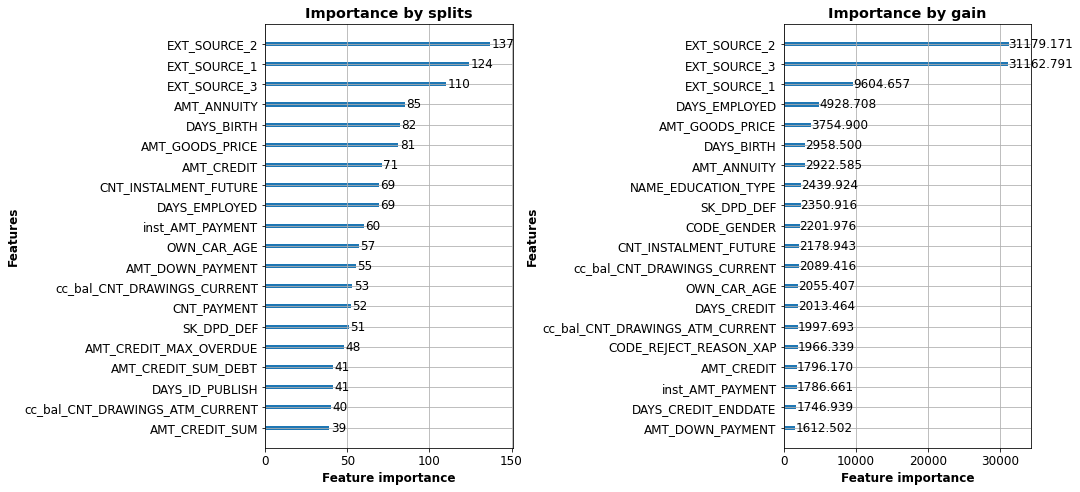

In [70]:
%%time
evals_result = {}
""" Predict on test set and create submission """
clf = lgbm.train(train_set=lgbm_train,
                 params=lgbm_params,
#                  valid_sets=[lgbm_train, lgbm_valid],
#                  evals_result=evals_result,
#                  verbose_eval=50,
                  feval=eval_fonct,
                 num_boost_round=optimum_boost_rounds)
clf.params['objective'] = 'probability'
contrib = clf.predict(X_test, pred_contrib =True)
y_pred = clf.predict(X_test)
# out_df = pd.DataFrame({'SK_ID_CURR': meta_df['SK_ID_CURR'][len_train:], 'TARGET': y_pred})
# out_df.to_csv('submission.csv', index=False)

fig, (ax, ax1) = plt.subplots(1, 2, figsize=[15, 7])
# doc sur les paramètres de lgbm.plot_importance
# importance_type (string, optional (default="split")) – How the importance is calculated. 
# If “split”, result contains numbers of times the feature is used in a model. 
# If “gain”, result contains total gains of splits which use the feature.
lgbm.plot_importance(clf, ax=ax, max_num_features=20, importance_type='split')
lgbm.plot_importance(clf, ax=ax1, max_num_features=20, importance_type='gain')
ax.set_title('Importance by splits')
ax1.set_title('Importance by gain')
plt.tight_layout()
# plt.savefig('feature_importance.png')

In [71]:
clf.params

{'boosting': 'dart',
 'application': 'binary',
 'learning_rate': 0.1,
 'min_data_in_leaf': 30,
 'num_leaves': 31,
 'max_depth': -1,
 'feature_fraction': 0.5,
 'scale_pos_weight': 1.4,
 'drop_rate': 0.025,
 'reg_lambda': 14,
 'sigmoid': 0.3,
 'objective': 'probability'}

In [72]:
# clf.params['objective'] = 'binary'
# clf.params['objective'] = 'probability'

# https://github.com/slundberg/shap/issues/1042
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


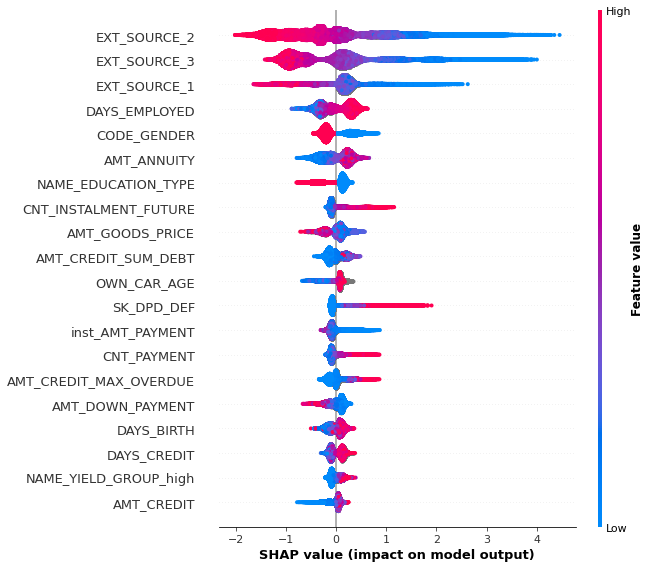

In [73]:
shap.summary_plot(shap_values, X_test)

In [74]:
len(shap_values)

101479

In [75]:
base = explainer.expected_value
base

-6.421604832682871

In [76]:
1/(1+np.exp(-base))

0.0016234048814466357

In [77]:
np.log(y_test.sum()/(len(y_test)-y_test.sum()))

-2.442523782420533

In [78]:
np.log(y_train.sum()/(len(y_train)-y_train.sum()))

-2.4275721864283883

In [79]:
df_homecredit[df_homecredit["Row"]=="AMT_ANNUITY"]

,Unnamed: 0,Table,Row,Description,Special
9,12,application_{train|test}.csv,AMT_ANNUITY,Loan annuity,NaN
138,141,bureau.csv,AMT_ANNUITY,Annuity of the Credit Bureau credit,NaN
176,179,previous_application.csv,AMT_ANNUITY,Annuity of previous application,NaN


In [80]:
df_application_train.loc[df_application_train["TARGET"]==1, "AMT_ANNUITY"].mean()

26481.744290030212

In [81]:
df_application_train.loc[df_application_train["TARGET"]==0, "AMT_ANNUITY"].mean()

27163.62334880463

In [82]:
help(shap.summary_plot)

Help on function summary_plot in module shap.plots.summary:

summary_plot(shap_values, features=None, feature_names=None, max_display=None, plot_type=None, color=None, axis_color='#333333', title=None, alpha=1, show=True, sort=True, color_bar=True, plot_size='auto', layered_violin_max_num_bins=20, class_names=None, class_inds=None, color_bar_label='Feature value', auto_size_plot=None)
    Create a SHAP summary plot, colored by feature values when they are provided.
    
    Parameters
    ----------
    shap_values : numpy.array
        For single output explanations this is a matrix of SHAP values (# samples x # features).
        For multi-output explanations this is a list of such matrices of SHAP values.
    
    features : numpy.array or pandas.DataFrame or list
        Matrix of feature values (# samples x # features) or a feature_names list as shorthand
    
    feature_names : list
        Names of the features (length # features)
    
    max_display : int
        How many top

infos sur l'utilisation de predict avec pred_contrib=True :  
https://github.com/microsoft/LightGBM/issues/1969

outil pour l'interprétation : SHAP  
https://github.com/slundberg/shap

In [83]:
y_pred.shape

(101479,)

In [84]:
contrib.shape

(101479, 375)

In [85]:
y_pred.mean()

0.15194205502376454

In [86]:
contrib[:,:-1].mean()

-8.881055309834426e-06

In [87]:
np.unique(contrib[:,-1])

array([-6.42160483])

In [88]:
y_pred[:10]

array([0.33872559, 0.10285446, 0.25680423, 0.06684538, 0.08620232,
       0.28536821, 0.0855378 , 0.25820916, 0.15308507, 0.09951193])

In [89]:
data.shape

(307511, 374)

## Calcul du seuil


Nous travaillons pour un organisme de crédit. Nous voulons donc minimiser le risque que le crédit ne soit pas remboursé. Nous voulons donc minimiser le nombre de faux négatifs, c'est à dire les personnes auxquelles on accorderait un crédit et qui ne seraient pas en mesure de le rembourser.    

Calculons le seuil correspondant à un taux de faux négatifs (FN/(FN+TP))choisi.  
Pour avoir un taux de faux négatifs < 5%, il faut un taux de vrai positifs (TP/(FN+TP))>95%.

In [90]:
if eval_fonct_str=="eval_auc":
    fpr, tpr, th = roc_curve(y_test, y_pred)
    fn_max = 0.05
    idx = np.min(np.where(tpr>(1-fn_max)))
#     print(f"Pour un taux de faux négatif de {fn_max*100}%, ")
#     print(f"le taux de faux positifs est de {fpr[idx]*100:.1f}%,")
#     print(f"et le seuil est de {th[idx]*100:.1f}%")
    seuil = th[idx]
    print("seuil : ", seuil)
    conf_matrix(y_test, y_pred, seuil)
elif eval_fonct_str =="eval_average_precision":
    prec, rec, th = precision_recall_curve(y_test, y_pred)
    fn_max = 0.15
    idx = np.max(np.where(rec>(1-fn_max)))
    seuil = th[idx]
    print("seuil : ", seuil)
    conf_matrix(y_test, y_pred, seuil)
elif eval_fonct_str in ["eval_Kulczynski_mod"]:
    thresholds = np.arange(0,1, 0.01)
    scores = [eval_fonct_score(y_test, y_pred, t, eval_fonct_param1) for t in thresholds]
    idx = np.argmax(scores[1:])
    score  = scores[idx]
    seuil = thresholds[idx]
    print("seuil : ", seuil)
    print("score : ", score)
    conf_matrix(y_test, y_pred, seuil)
elif eval_fonct_str == "eval_perso1":
    thresholds = np.arange(0,1, 0.01)
    scores = [eval_fonct_score(y_test, y_pred, t, eval_fonct_param1, eval_fonct_param2) for t in thresholds]
    idx = np.argmax(scores[1:])
    score  = scores[idx]
    seuil = thresholds[idx]
    print("seuil : ", seuil)
    print("score : ", score)
    conf_matrix(y_test, y_pred, seuil)
elif eval_fonct_str == "eval_tanimoto_mod":
    thresholds = np.arange(0,1, 0.01)
    scores = [eval_fonct_score(y_test, y_pred, t) for t in thresholds]
    idx = np.argmax(scores[1:])
    score  = scores[idx]
    seuil = thresholds[idx]
    print("seuil : ", seuil)
    print("score : ", score)
    conf_matrix(y_test, y_pred, seuil)
elif eval_fonct_str == "fbeta_eval3":
    thresholds = np.arange(0,1, 0.01)
    scores = [eval_fonct_score(y_test, to_labels(y_pred, t), eval_fonct_param1) for t in thresholds]
    idx = np.argmax(scores[1:])
    score  = scores[idx]
    seuil = thresholds[idx]
    print("seuil : ", seuil)
    print("score : ", score)
    conf_matrix(y_test, y_pred, seuil)
   

seuil :  0.07423878853323482
tp :  7712
tn :  25238
fp :  68124
fn :  405
fpr = 72.97%
fnr = 4.99%
precision = 10.17%
recall = 95.01%


In [91]:
# pd.Series(y_pred).to_csv("y_pred_fbeta3_95.csv", index = False)

**fbeta_score, beta=4**  
tp :  7898  
tn :  16390  
fp :  76972  
fn :  219  
fpr = 82.44%  
fnr = 2.70%  
precision = 9.31%  
recall = 97.30%  

**fbeta_score, beta=3.8**  
seuil :  0.05  
score :  0.6207372298025252  
tp :  7602  
tn :  29084  
fp :  64278  
fn :  515  
fpr = 68.85%  
fnr = 6.34%  
precision = 10.58%  
recall = 93.66%  

**fbeta_score, beta=3.6**  
seuil :  0.06  
score :  0.6108316344692227  
tp :  7331  
tn :  38346  
fp :  55016  
fn :  786  
fpr = 58.93%  
fnr = 9.68%  
precision = 11.76%  
recall = 90.32%  

**fbeta_score, beta=3**   
tp :  6876  
tn :  48479  
fp :  44883  
fn :  1241  
fpr = 48.07%  
fnr = 15.29%  
precision = 13.28%  
recall = 84.71%  

**fbeta_score, beta=3, 1000 rounds**   
seuil :  0.07  
score :  0.557031555613509  
tp :  6835  
tn :  50546  
fp :  42816  
fn :  1282  
fpr = 45.86%  
fnr = 15.79%  
precision = 13.77%  
recall = 84.21%  

**fbeta_score, beta = 2**    
tp :  5502  
tn :  68102  
fp :  25260  
fn :  2615  
fpr = 27.06%  
fnr = 32.22%  
precision = 17.89%  
recall = 67.78%  

**AUC**    
tp : 7712  
tn : 27154  
fp : 66208  
fn : 405  
fpr : 0.7091536171033183  
fnr : 0.04989528150794629  
precision : 0.10432900432900433  
recall : 0.9501047184920537  


**average_precision**  
seuil :  0.07509545445933284  
tp :  7712  
tn :  25559  
fp :  67803  
fn :  405  
fpr = 72.62%  
fnr = 4.99%  
precision = 10.21%  
recall = 95.01%   

**balanced_accuracy_score**    
tp :  5374  
tn :  69599  
fp :  23763  
fn :  2743  
fpr = 25.45%  
fnr = 33.79%  
precision = 18.44%  
recall = 66.21%  

**Matthews**  
tp :  5146  
tn :  71592  
fp :  21770  
fn :  2971  
fpr = 23.32%  
fnr = 36.60%  
precision = 19.12%  
recall = 63.40%  

**tanimoto_mod**    
seuil :  0.41000000000000003  
score :  0.750621228257011  
tp :  1103  
tn :  91935  
fp :  1427  
fn :  7014  
fpr = 1.53%  
fnr = 86.41%  
precision = 43.60%  
recall = 13.59%  

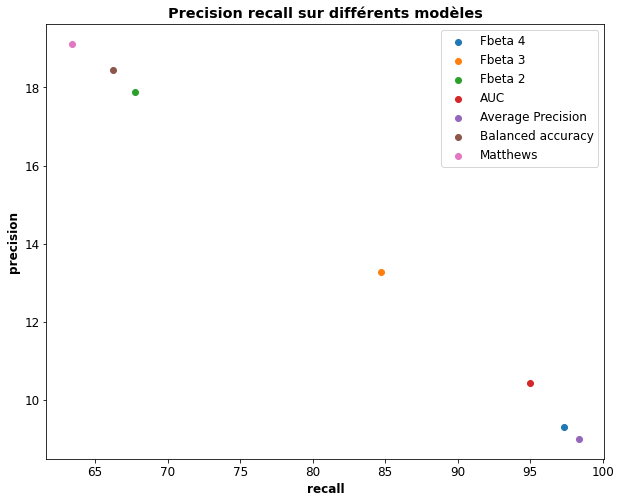

In [92]:
plt.scatter(y=9.31, x=97.3, label="Fbeta 4")
plt.scatter(y=13.28, x=84.71, label="Fbeta 3")
plt.scatter(y=17.89, x=67.78, label="Fbeta 2")
plt.scatter(y=10.43, x=95, label="AUC")
plt.scatter(y=9, x=98.36, label="Average Precision")
plt.scatter(y=18.44, x=66.21, label="Balanced accuracy")
plt.scatter(y=19.12, x=63.40, label="Matthews")
plt.legend()
plt.title("Precision recall sur différents modèles")
plt.xlabel("recall")
plt.ylabel("precision")
plt.show()


In [93]:
# prec, rec, th = precision_recall_curve(y_test, y_pred)
# plt.plot(rec, prec)
# plt.xlabel("recall")
# plt.ylabel("precision")
# plt.title("optimisation de Average Precision")
# plt.show()

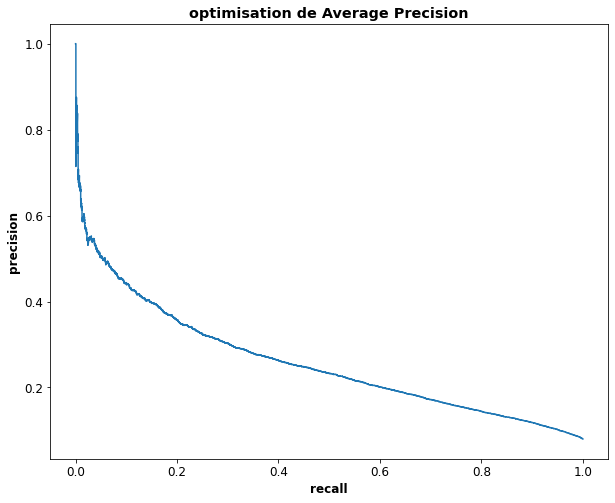

# Explicabilité

## Préparation des données

Nous reprenons le modèle qui a déjà été entraîné (sur le jeu d'entraînement) et nous l'utilisons maintenant pour prédire la totalité des données.  
Mais avant, nous allons modifier la colonne DAYS_EMPLOYED. Cette colonne contient une valeur conventionnelle pour certaines personnes.

In [429]:
data["DAYS_EMPLOYED"].describe()

count    252137.000000
mean      -2384.169325
std        2338.360162
min      -17912.000000
25%       -3175.000000
50%       -1648.000000
75%        -767.000000
max           0.000000
Name: DAYS_EMPLOYED, dtype: float64

In [95]:
(data["DAYS_EMPLOYED"]==365243).sum()

0

In [96]:
data["DAYS_EMPLOYED"].quantile(0.81)

-587.0

In [428]:
data.loc[data["DAYS_EMPLOYED"]>0, "DAYS_EMPLOYED"].value_counts()

Series([], Name: DAYS_EMPLOYED, dtype: int64)

Nous remarquons que "DAYS_EMPLOYED" contient surtout des valeurs des valeurs négatives. Il n'y a qu'une seule valeur positive qui correpond à une durée de 1000 ans. Nous supposons que cette valeur correspond aux personnes soit qui n'ont pas de travail, soit pour lesquelles il n'y a pas d'information. Nous allons remplacer cette valeur par null.  
De plus, nous allons rendre prositives les valeurs de cette colonne.

In [98]:
#data.loc[data["DAYS_EMPLOYED"]>0, "DAYS_EMPLOYED"] = np.nan

In [430]:
data["DAYS_EMPLOYED"] = -data["DAYS_EMPLOYED"]
df_data_true["DAYS_EMPLOYED"] = -df_data_true["DAYS_EMPLOYED"]

In [431]:
df_data_true["DAYS_EMPLOYED"]

0          637.0
1         1188.0
2          225.0
3         3039.0
4         3038.0
           ...  
307506     236.0
307507       NaN
307508    7921.0
307509    4786.0
307510    1262.0
Name: DAYS_EMPLOYED, Length: 307511, dtype: float64

In [433]:
data["DAYS_EMPLOYED"]

0          637.0
1         1188.0
2          225.0
3         3039.0
4         3038.0
           ...  
307506     236.0
307507       NaN
307508    7921.0
307509    4786.0
307510    1262.0
Name: DAYS_EMPLOYED, Length: 307511, dtype: float64

In [432]:
y_pred = clf.predict(data)
contrib = clf.predict(data, pred_contrib =True)
y_pred

array([0.51964479, 0.06456949, 0.07741825, ..., 0.16060538, 0.14154277,
       0.16712313])

In [322]:
contrib[:, -1]

array([-6.42160483, -6.42160483, -6.42160483, ..., -6.42160483,
       -6.42160483, -6.42160483])

In [323]:
y_pred

array([0.51964479, 0.06456949, 0.07741825, ..., 0.16060538, 0.14154277,
       0.16712313])

In [325]:
contrib

array([[ 2.42557764e-02,  2.33618046e-01,  2.67858837e-03, ...,
        -1.92578691e-02, -5.27671470e-02, -6.42160483e+00],
       [ 6.22239469e-03, -2.44360070e-01,  1.10448917e-02, ...,
        -5.57836363e-02, -1.76183730e-01, -6.42160483e+00],
       [-1.17320200e-01,  4.75700916e-01, -1.74025737e-02, ...,
         4.32988300e-02,  3.88001268e-02, -6.42160483e+00],
       ...,
       [ 9.06498709e-03, -1.58719899e-01,  1.26784788e-02, ...,
         1.06214460e-01,  3.25289743e-01, -6.42160483e+00],
       [ 8.49382888e-03, -2.28012988e-01,  2.55025864e-03, ...,
         5.45148874e-04, -1.04173231e-01, -6.42160483e+00],
       [ 2.35573778e-02, -1.51716203e-01,  2.03214640e-03, ...,
        -4.02375694e-02, -8.98259398e-02, -6.42160483e+00]])

In [326]:
# fpr, tpr, th = roc_curve(y, y_pred[:,1])
# auc_test =  auc(fpr, tpr)
# auc_test

In [434]:
df_data_applicant = pd.concat([applicants, pd.Series(y_pred, name="score"), data], axis=1)
df_data_applicant

,SK_ID_CURR,score,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,cc_bal_cc_bal_status__Demand,cc_bal_cc_bal_status__Refused,cc_bal_cc_bal_status__Sent_proposal,cc_bal_cc_bal_status__Signed,inst_NUM_INSTALMENT_VERSION,inst_NUM_INSTALMENT_NUMBER,inst_DAYS_INSTALMENT,inst_DAYS_ENTRY_PAYMENT,inst_AMT_INSTALMENT,inst_AMT_PAYMENT
0,100002,0.519645,0,0,0,0,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,1.052632,10.000000,-295.000000,-315.421053,11559.247105,11559.247105
1,100003,0.064569,0,1,0,1,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,1.040000,5.080000,-1378.160000,-1385.320000,64754.586000,64754.586000
2,100004,0.077418,1,0,1,0,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,1.333333,2.000000,-754.000000,-761.666667,7096.155000,7096.155000
3,100006,0.080845,0,1,0,0,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,1.125000,4.437500,-252.250000,-271.625000,62947.088438,62947.088438
4,100007,0.189751,0,0,0,0,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,1.166667,7.045455,-1028.606061,-1032.242424,12666.444545,12214.060227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0.224137,0,0,0,1,0,157500.0,254700.0,27558.0,...,NaN,NaN,NaN,NaN,1.142857,4.000000,-120.000000,-156.285714,7492.924286,7492.924286
307507,456252,0.188498,0,1,0,0,0,72000.0,269550.0,12001.5,...,NaN,NaN,NaN,NaN,1.000000,3.500000,-2391.000000,-2393.833333,10069.867500,10069.867500
307508,456253,0.160605,0,1,0,0,0,153000.0,677664.0,29979.0,...,NaN,NaN,NaN,NaN,1.000000,4.785714,-2372.928571,-2387.428571,4399.707857,4115.915357
307509,456254,0.141543,0,1,0,0,0,171000.0,370107.0,20205.0,...,NaN,NaN,NaN,NaN,1.000000,5.263158,-142.263158,-161.263158,10239.832895,10239.832895


In [436]:
feature_gain = pd.concat([pd.Series(clf.feature_name(), name="feature"),
    pd.Series(clf.feature_importance(importance_type='gain'), name="gain")], axis=1)
feature_gain.sort_values(by="gain", ascending=False).head(20)

,feature,gain
40,EXT_SOURCE_2,31179.171174
41,EXT_SOURCE_3,31162.791412
39,EXT_SOURCE_1,9604.657203
16,DAYS_EMPLOYED,4928.707894
8,AMT_GOODS_PRICE,3754.899591
15,DAYS_BIRTH,2958.500440
7,AMT_ANNUITY,2922.585094
11,NAME_EDUCATION_TYPE,2439.923791
331,SK_DPD_DEF,2350.915982
1,CODE_GENDER,2201.975531


In [329]:
(feature_gain["gain"]==0.).sum()

141

## Données pour l'explicabilité

In [437]:
#clf.params['objective'] = 'probability'
# https://github.com/slundberg/shap/issues/1042

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(data)


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [331]:
help(explainer.shap_values)

Help on method shap_values in module shap.explainers.tree:

shap_values(X, y=None, tree_limit=None, approximate=False, check_additivity=True) method of shap.explainers.tree.TreeExplainer instance
    Estimate the SHAP values for a set of samples.
    
    Parameters
    ----------
    X : numpy.array, pandas.DataFrame or catboost.Pool (for catboost)
        A matrix of samples (# samples x # features) on which to explain the model's output.
    
    y : numpy.array
        An array of label values for each sample. Used when explaining loss functions.
    
    tree_limit : None (default) or int
        Limit the number of trees used by the model. By default None means no use the limit of the
        original model, and -1 means no limit.
    
    approximate : bool
        Run fast, but only roughly approximate the Tree SHAP values. This runs a method
        previously proposed by Saabas which only considers a single feature ordering. Take care
        since this does not have the cons

In [332]:
help(explainer)

Help on TreeExplainer in module shap.explainers.tree object:

class TreeExplainer(shap.explainers.explainer.Explainer)
 |  TreeExplainer(model, data=None, model_output='raw', feature_perturbation='interventional', **deprecated_options)
 |  
 |  Uses Tree SHAP algorithms to explain the output of ensemble tree models.
 |  
 |  Tree SHAP is a fast and exact method to estimate SHAP values for tree models and ensembles of trees,
 |  under several different possible assumptions about feature dependence. It depends on fast C++
 |  implementations either inside an externel model package or in the local compiled C extention.
 |  
 |  Parameters
 |  ----------
 |  model : model object
 |      The tree based machine learning model that we want to explain. XGBoost, LightGBM, CatBoost, Pyspark
 |      and most tree-based scikit-learn models are supported.
 |  
 |  data : numpy.array or pandas.DataFrame
 |      The background dataset to use for integrating out features. This argument is optional whe

In [333]:
shap_values

array([[ 0.02425578,  0.23361805,  0.00267859, ...,  0.01018283,
        -0.01925787, -0.05276715],
       [ 0.00622239, -0.24436007,  0.01104489, ..., -0.01700472,
        -0.05578364, -0.17618373],
       [-0.1173202 ,  0.47570092, -0.01740257, ...,  0.00541224,
         0.04329883,  0.03880013],
       ...,
       [ 0.00906499, -0.1587199 ,  0.01267848, ..., -0.01820958,
         0.10621446,  0.32528974],
       [ 0.00849383, -0.22801299,  0.00255026, ...,  0.04546978,
         0.00054515, -0.10417323],
       [ 0.02355738, -0.1517162 ,  0.00203215, ...,  0.00531725,
        -0.04023757, -0.08982594]])

In [334]:
explainer.expected_value

-6.421604832682871

In [335]:
odds_train = (y_train==1).sum()/(y_train==0).sum()
odds_train

0.08825082926623143

In [336]:
np.log(odds_train)

-2.4275721864283883

In [337]:
np.log(np.mean(y_train))

-2.512143849896499

In [338]:
shap_values.sum()

75660.19415828514

In [339]:
np.exp(explainer.expected_value)

0.0016260446102042913

In [340]:
odds = np.exp(-explainer.expected_value)
odds

614.9892774924318

expected_value (base value) est le logarithme de la cote (?? odds) de chaque classe. p(0)/p(1).  
Comme p(0) > p(1), p(0)/p(1) > 1 et ln(p(0)/p(1))>0.  
De même p(1)/p(0) < 1 et ln( p(1)/p(0 ) <0.

In [341]:
np.log(y_train.sum()/len(y_train))

-2.512143849896499

In [342]:
np.log(y_train.sum()/(len(y_train)-y_train.sum()))

-2.4275721864283883

In [343]:
np.sum(contrib[:,:-1])

75660.19415828514

In [344]:
np.log((y_train==1).sum()/(y_train==0).sum()*100)

2.177597999559703

In [345]:
y_pred.mean()

0.16016665780891523

## Analyse d'une demande

In [438]:
np.random.seed(42)

In [439]:
this_client = np.random.randint(0, len(y))
this_client

121958

### Description du client

In [440]:
no_client = df_data_applicant.loc[this_client, "SK_ID_CURR"]
print("numéro de client : ", no_client)
genre = df_data_applicant.loc[this_client, "CODE_GENDER"]
if genre==0:
    print("genre : masculin")
else :
    print("genre : féminin")
age_jours = df_data_applicant.loc[this_client, "DAYS_BIRTH"]
print(f"âge : {-age_jours/365:.0f} ans")

numéro de client :  241394
genre : masculin
âge : 36 ans


In [441]:
df_homecredit[df_homecredit["Row"]=="CNT_INSTALMENT"]

,Unnamed: 0,Table,Row,Description,Special
145,148,POS_CASH_balance.csv,CNT_INSTALMENT,Term of previous credit (can change over time),NaN


In [442]:
list(df_homecredit[df_homecredit["Row"]=="AMT_GOODS_PRICE"]["Description"])

['For consumer loans it is the price of the goods for which the loan is given',
 'Goods price of good that client asked for (if applicable) on the previous application']

In [351]:
# df_application_train["AMT_ANNUITY"].describe()
df_pos_cash_balance["CNT_INSTALMENT_FUTURE"].describe()

count    9.975271e+06
mean     1.048384e+01
std      1.110906e+01
min      0.000000e+00
25%      3.000000e+00
50%      7.000000e+00
75%      1.400000e+01
max      8.500000e+01
Name: CNT_INSTALMENT_FUTURE, dtype: float64

In [352]:
df_prev_app.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY',
       'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY',
       'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY',
       'RATE_INTEREST_PRIVILEGED', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_CONTRACT_STATUS', 'DAYS_DECISION', 'NAME_PAYMENT_TYPE',
       'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE',
       'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE',
       'CHANNEL_TYPE', 'SELLERPLACE_AREA', 'NAME_SELLER_INDUSTRY',
       'CNT_PAYMENT', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
       'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
       'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL'],
      dtype='object')

### Score et interprétation

In [353]:
score = df_data_applicant.loc[this_client, "score"]
print("Score : " + f"{score*100:.1f} %")
if score < seuil :
    print("==> pas de risque particulier")
else :
    print("==> client à risque")
score_ext_1, score_ext_2, score_ext_3 = df_data_applicant.loc[this_client, ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]]
print(f"Scores externes : score 1 : {score_ext_1*100:.0f}%, score 2 : {score_ext_2*100:.0f}%, score 3 : {score_ext_3*100:.0f}%")
annuity = df_data_applicant.loc[this_client, "AMT_ANNUITY"]
print(f"Montant de l'annuité : {annuity:.2f}")
goods_price = df_data_applicant.loc[this_client, "AMT_GOODS_PRICE"]
print(f"Prix du bien acheté : {goods_price}")
installment_prev_credit = df_data_applicant.loc[this_client, "CNT_INSTALMENT_FUTURE"]
print(f"Nombre de versements restants de précédents crédits : {installment_prev_credit}")

Score : 21.3 %
==> client à risque
Scores externes : score 1 : 35%, score 2 : 41%, score 3 : 28%
Montant de l'annuité : 35239.50
Prix du bien acheté : 630000.0
Nombre de versements restants de précédents crédits : 8.4


In [354]:
clf.predict(df_data_applicant.iloc[this_client, 2:])

Converting data to scipy sparse matrix.


array([0.21322974])

In [355]:
df_data_applicant.iloc[this_client, :]

SK_ID_CURR                    241394.00000
score                              0.21323
NAME_CONTRACT_TYPE                 0.00000
CODE_GENDER                        0.00000
FLAG_OWN_CAR                       1.00000
                                  ...     
inst_NUM_INSTALMENT_NUMBER         2.50000
inst_DAYS_INSTALMENT            -786.00000
inst_DAYS_ENTRY_PAYMENT         -811.75000
inst_AMT_INSTALMENT            12803.10750
inst_AMT_PAYMENT               12803.10750
Name: 121958, Length: 376, dtype: float64

In [356]:
contrib[:,-1]

array([-6.42160483, -6.42160483, -6.42160483, ..., -6.42160483,
       -6.42160483, -6.42160483])

In [357]:
contrib[:,:-1].sum()

75660.19415828514

In [358]:
np.log(0.21)

-1.5606477482646683

In [359]:
np.log(0.08/0.92)

-2.4423470353692043

In [360]:
np.where(data.columns=="CODE_GENDER")

(array([1], dtype=int64),)

In [361]:
y_train.mean()

0.08109419895938495

In [362]:
data.iloc[this_client,:]

NAME_CONTRACT_TYPE                0.0000
CODE_GENDER                       0.0000
FLAG_OWN_CAR                      1.0000
FLAG_OWN_REALTY                   0.0000
CNT_CHILDREN                      0.0000
                                 ...    
inst_NUM_INSTALMENT_NUMBER        2.5000
inst_DAYS_INSTALMENT           -786.0000
inst_DAYS_ENTRY_PAYMENT        -811.7500
inst_AMT_INSTALMENT           12803.1075
inst_AMT_PAYMENT              12803.1075
Name: 121958, Length: 374, dtype: float64

In [363]:
len(shap_values[this_client,:])

374

In [364]:
1/(1+np.exp(-0.081))

0.5202389355718147

In [365]:
p=0.081
np.log(p/(1-p))

-2.428836967683248

In [366]:
np.log(p)

-2.513306124309698

In [367]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[this_client,:], data.iloc[this_client,:])
# shap.force_plot(explainer.expected_value[1], shap_values[1][this_client,:], data.iloc[this_client,:], link="logit")
# shap.visualize(shap_values[this_client,:], data.iloc[this_client,:], link=shap.LogitLink())

In [368]:
shap_values[this_client,:].sum()+explainer.expected_value

-4.35188708072784

On a donc,  (somme des shap values de l'individu) + (base value) = model output value  
soit (somme des contributions des features) + (valeur de base) = valeur de l'individu

In [369]:
explainer.expected_value

-6.421604832682871

In [370]:
df_shap_values = pd.DataFrame(data=shap_values, columns = data.columns)

In [371]:
df_shap_values.iloc[this_client, :].sort_values()

NAME_EDUCATION_TYPE   -0.516802
OWN_CAR_AGE           -0.463888
inst_AMT_PAYMENT      -0.154826
ca__Closed            -0.110568
AMT_CREDIT_SUM_DEBT   -0.106033
                         ...   
DAYS_EMPLOYED          0.277424
AMT_ANNUITY            0.340348
CODE_GENDER            0.393733
EXT_SOURCE_2           0.601010
EXT_SOURCE_3           1.061379
Name: 121958, Length: 374, dtype: float64

In [372]:
df_data_applicant.loc[this_client, "NAME_EDUCATION_TYPE"]

1

In [373]:
df_homecredit[df_homecredit["Row"]=="NAME_EDUCATION_TYPE"]

,Unnamed: 0,Table,Row,Description,Special
13,16,application_{train|test}.csv,NAME_EDUCATION_TYPE,Level of highest education the client achieved,NaN


In [374]:
help(shap.force_plot)

Help on function force_plot in module shap.plots.force:

force_plot(base_value, shap_values, features=None, feature_names=None, out_names=None, link='identity', plot_cmap='RdBu', matplotlib=False, show=True, figsize=(20, 3), ordering_keys=None, ordering_keys_time_format=None, text_rotation=0)
    Visualize the given SHAP values with an additive force layout.
    
    Parameters
    ----------
    base_value : float
        This is the reference value that the feature contributions start from. For SHAP values it should
        be the value of explainer.expected_value.
    
    shap_values : numpy.array
        Matrix of SHAP values (# features) or (# samples x # features). If this is a 1D array then a single
        force plot will be drawn, if it is a 2D array then a stacked force plot will be drawn.
    
    features : numpy.array
        Matrix of feature values (# features) or (# samples x # features). This provides the values of all the
        features, and should be the same shap

In [375]:
shap.force_plot(explainer.expected_value, shap_values[this_client,:], data.iloc[this_client,:], link="logit")


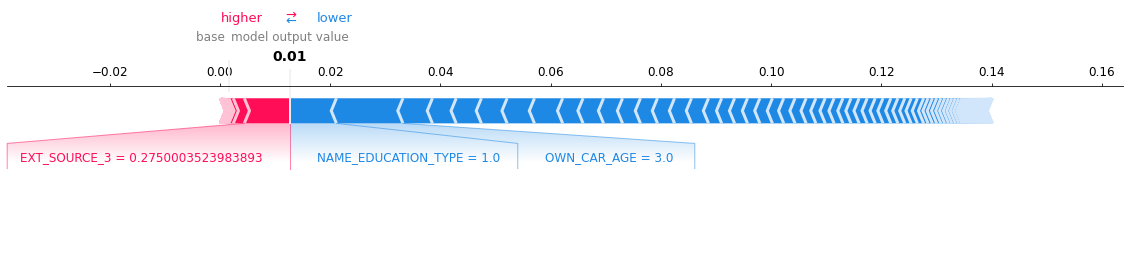

In [376]:
shap.force_plot(explainer.expected_value, shap_values[this_client,:], data.iloc[this_client,:], link="logit", matplotlib=True)

In [377]:
np.log(0.01/0.99)

-4.59511985013459

In [378]:
df_shap_values.iloc[this_client, :].sum()

2.069717751955032

In [379]:
df_shap_values.shape

(307511, 374)

In [380]:
df_data_applicant.iloc[this_client,:]

SK_ID_CURR                    241394.00000
score                              0.21323
NAME_CONTRACT_TYPE                 0.00000
CODE_GENDER                        0.00000
FLAG_OWN_CAR                       1.00000
                                  ...     
inst_NUM_INSTALMENT_NUMBER         2.50000
inst_DAYS_INSTALMENT            -786.00000
inst_DAYS_ENTRY_PAYMENT         -811.75000
inst_AMT_INSTALMENT            12803.10750
inst_AMT_PAYMENT               12803.10750
Name: 121958, Length: 376, dtype: float64

In [381]:
# https://www.kaggle.com/dansbecker/shap-values
# https://towardsdatascience.com/one-feature-attribution-method-to-supposedly-rule-them-all-shapley-values-f3e04534983d
# https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d

### Comparaison à des clients semblables

In [382]:
facteurs_favorables = df_shap_values.iloc[this_client, :].sort_values().head().keys()
facteurs_favorables

Index(['NAME_EDUCATION_TYPE', 'OWN_CAR_AGE', 'inst_AMT_PAYMENT', 'ca__Closed',
       'AMT_CREDIT_SUM_DEBT'],
      dtype='object')

In [383]:
facteurs_risque = df_shap_values.iloc[this_client, :].sort_values().tail().keys()
facteurs_risque

Index(['DAYS_EMPLOYED', 'AMT_ANNUITY', 'CODE_GENDER', 'EXT_SOURCE_2',
       'EXT_SOURCE_3'],
      dtype='object')

In [384]:
print("Facteurs favorables : ")
for f in facteurs_favorables :
    print(f, df_data_applicant.loc[this_client, f])

print("\nFacteurs de risque : ")
for f in facteurs_risque :
    print(f, df_data_applicant.loc[this_client, f])

Facteurs favorables : 
NAME_EDUCATION_TYPE 1
OWN_CAR_AGE 3.0
inst_AMT_PAYMENT 12803.107499999998
ca__Closed 1.0
AMT_CREDIT_SUM_DEBT 0.0

Facteurs de risque : 
DAYS_EMPLOYED 733.0
AMT_ANNUITY 35239.5
CODE_GENDER 0
EXT_SOURCE_2 0.4084003044667711
EXT_SOURCE_3 0.2750003523983893


Facteurs favorables : 


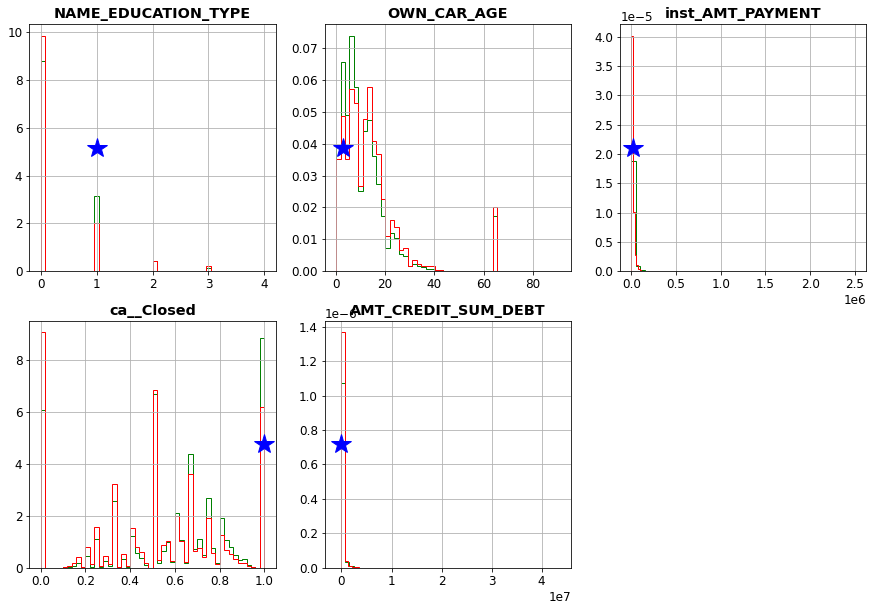


Facteurs de risque : 


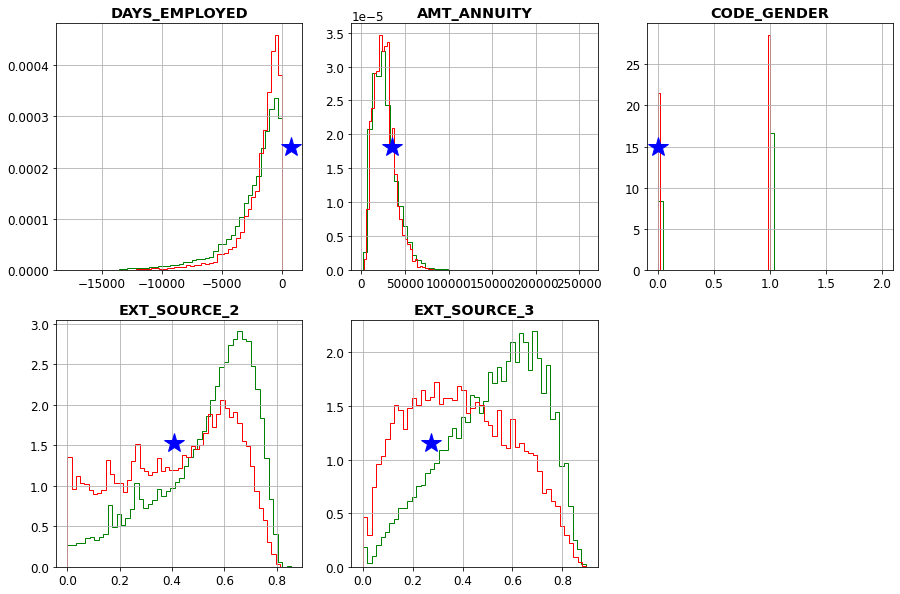

In [385]:
print("Facteurs favorables : ")
plt.figure(figsize=(15,10))
for i, f in enumerate(facteurs_favorables) :
    plt.subplot(2,3, i +1)
#     print(f, df_data_applicant.loc[this_client, f])
# #     print(f, df_data_true.loc[df_data_true["risk"]==0, f].mean())
#     print(f, df_data_true.loc[df_data_true["risk"]==0, f].quantile(0.25))
#     print(f, df_data_true.loc[df_data_true["risk"]==0, f].quantile(0.75))
    nf = df_data_true.loc[df_data_true["risk"]==0, f].hist(density=True, bins=50, histtype='step', color="green")
    nr = df_data_true.loc[df_data_true["risk"]==1, f].hist(density=True, bins=50, histtype='step', color="red")
    y_plot = max(nf.get_ylim()[1], nr.get_ylim()[1])/2
    plt.plot(df_data_applicant.loc[this_client, f], y_plot, color="blue", marker="*", markersize=20)    
    plt.title(f)
plt.show()
    
    
print("\nFacteurs de risque : ")
plt.figure(figsize=(15,10))
for i, f in enumerate(facteurs_risque) :
    plt.subplot(2,3, i +1)
#     print(f, df_data_applicant.loc[this_client, f])
# #     print(f, df_data_true.loc[df_data_true["risk"]==0, f].mean())
#     print(f, df_data_true.loc[df_data_true["risk"]==0, f].quantile(0.25))
#     print(f, df_data_true.loc[df_data_true["risk"]==0, f].quantile(0.75))
    nf = df_data_true.loc[df_data_true["risk"]==0, f].hist(density=True, bins=50, histtype='step', color="green")
    nr = df_data_true.loc[df_data_true["risk"]==1, f].hist(density=True, bins=50, histtype='step', color="red")
    y_plot = max(nf.get_ylim()[1], nr.get_ylim()[1])/2
    plt.plot(df_data_applicant.loc[this_client, f], y_plot, color="blue", marker="*", markersize=20)    
    plt.title(f)

plt.show()


In [386]:
seuil

0.07423878853323482

Facteurs favorables : 


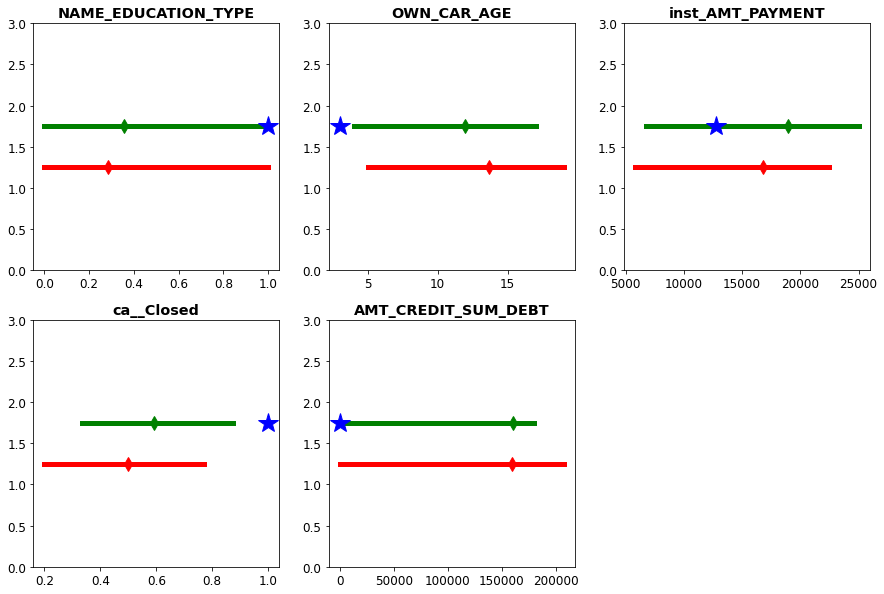


Facteurs de risque : 


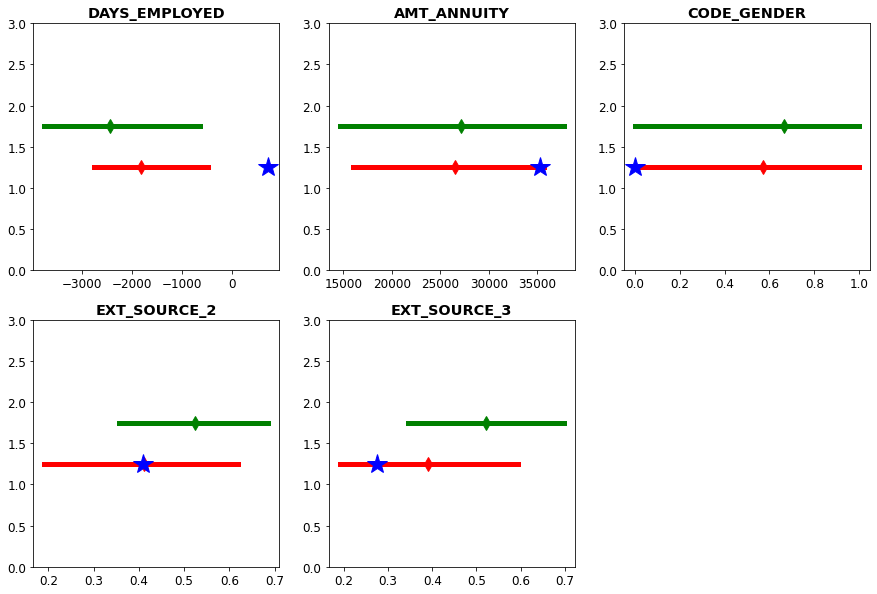

In [387]:
yplot_risque = 1.25
yplot_favorable = 1.75
# if score < seuil:
#     this_client_yplot = yplot_favorable
# else :
#     this_client_yplot = yplot_risque

    
print("Facteurs favorables : ")
plt.figure(figsize=(15,10))
for i, f in enumerate(facteurs_favorables) :
    ax = plt.subplot(2,3, i +1)
    qf10 = df_data_true.loc[df_data_true["risk"]==0, f].quantile(0.2)
    qf90 = df_data_true.loc[df_data_true["risk"]==0, f].quantile(0.8)
    fm = df_data_true.loc[df_data_true["risk"]==0, f].mean()
    qr10 = df_data_true.loc[df_data_true["risk"]==1, f].quantile(0.2)
    qr90 = df_data_true.loc[df_data_true["risk"]==1, f].quantile(0.8)
    rm = df_data_true.loc[df_data_true["risk"]==1, f].mean()
    plt.plot((qf10, qf90), (yplot_favorable,yplot_favorable), linewidth=5, color="green")
    plt.plot(fm, yplot_favorable, color="green", marker="d", markersize=10)    
    plt.plot((qr10, qr90), (yplot_risque,yplot_risque), linewidth=5, color="red")
    plt.plot(rm, yplot_risque, color="red", marker="d", markersize=10)    
    plt.plot(df_data_applicant.loc[this_client, f], yplot_favorable, color="blue", marker="*", markersize=20)    
    ax.set_ylim(0,3)
    plt.title(f)
plt.show()
    
    
print("\nFacteurs de risque : ")
plt.figure(figsize=(15,10))
for i, f in enumerate(facteurs_risque) :
    ax = plt.subplot(2,3, i +1)
    qf10 = df_data_true.loc[df_data_true["risk"]==0, f].quantile(0.2)
    qf90 = df_data_true.loc[df_data_true["risk"]==0, f].quantile(0.8)
    fm = df_data_true.loc[df_data_true["risk"]==0, f].mean()
    qr10 = df_data_true.loc[df_data_true["risk"]==1, f].quantile(0.2)
    qr90 = df_data_true.loc[df_data_true["risk"]==1, f].quantile(0.8)
    rm = df_data_true.loc[df_data_true["risk"]==1, f].mean()
    plt.plot((qf10, qf90), (yplot_favorable,yplot_favorable), linewidth=5, color="green")
    plt.plot(fm, yplot_favorable, color="green", marker="d", markersize=10)    
    plt.plot((qr10, qr90), (yplot_risque,yplot_risque), linewidth=5, color="red")
    plt.plot(rm, yplot_risque, color="red", marker="d", markersize=10)    
    plt.plot(df_data_applicant.loc[this_client, f], yplot_risque, color="blue", marker="*", markersize=20)    
    ax.set_ylim(0,3)
    plt.title(f)
plt.show()


In [388]:
# from flask import Flask
# from flask import render_template
# from flask import jsonify

# import json
# import requests

# TEST_URL = "http://localhost:5000/api/ref/"
# response = requests.get(TEST_URL)
# content = json.loads(response.content.decode('utf-8'))


# Préparation des données pour API

## Données de référence
Pour chaque colonne, nous calculons un percentile bas (ex 0.2) et un percentile haut(ex 0.8) ainsi que la moyenne. Et cela en séparant les personnes qui ont eu un problème de paiement de celles qui n'en ont pas eu.

In [443]:
df_data_true

,risk,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,cc_bal_cc_bal_status__Demand,cc_bal_cc_bal_status__Refused,cc_bal_cc_bal_status__Sent_proposal,cc_bal_cc_bal_status__Signed,inst_NUM_INSTALMENT_VERSION,inst_NUM_INSTALMENT_NUMBER,inst_DAYS_INSTALMENT,inst_DAYS_ENTRY_PAYMENT,inst_AMT_INSTALMENT,inst_AMT_PAYMENT
0,1,0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,1.052632,10.000000,-295.000000,-315.421053,11559.247105,11559.247105
1,0,0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,1.040000,5.080000,-1378.160000,-1385.320000,64754.586000,64754.586000
2,0,1,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,1.333333,2.000000,-754.000000,-761.666667,7096.155000,7096.155000
3,0,0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,0.0,1.125000,4.437500,-252.250000,-271.625000,62947.088438,62947.088438
4,0,0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,1.166667,7.045455,-1028.606061,-1032.242424,12666.444545,12214.060227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,0,0,0,1,0,157500.0,254700.0,27558.0,225000.0,...,NaN,NaN,NaN,NaN,1.142857,4.000000,-120.000000,-156.285714,7492.924286,7492.924286
307507,0,0,1,0,0,0,72000.0,269550.0,12001.5,225000.0,...,NaN,NaN,NaN,NaN,1.000000,3.500000,-2391.000000,-2393.833333,10069.867500,10069.867500
307508,0,0,1,0,0,0,153000.0,677664.0,29979.0,585000.0,...,NaN,NaN,NaN,NaN,1.000000,4.785714,-2372.928571,-2387.428571,4399.707857,4115.915357
307509,1,0,1,0,0,0,171000.0,370107.0,20205.0,319500.0,...,NaN,NaN,NaN,NaN,1.000000,5.263158,-142.263158,-161.263158,10239.832895,10239.832895


In [444]:
df_data_true["DAYS_EMPLOYED"]

0          637.0
1         1188.0
2          225.0
3         3039.0
4         3038.0
           ...  
307506     236.0
307507       NaN
307508    7921.0
307509    4786.0
307510    1262.0
Name: DAYS_EMPLOYED, Length: 307511, dtype: float64

In [445]:
%%time
ref = {}
for f in df_data_true.columns[1:] :
    # cas favorable
    fqb = df_data_true.loc[df_data_true["risk"]==0, f].quantile(0.2) #favorable, quantile bas
    fqh = df_data_true.loc[df_data_true["risk"]==0, f].quantile(0.8) #favorable, quantile haut
    fm = df_data_true.loc[df_data_true["risk"]==0, f].mean() #favorable, moyenne
    # cas à risque
    rqb = df_data_true.loc[df_data_true["risk"]==1, f].quantile(0.2) #risque, quantile bas
    rqh = df_data_true.loc[df_data_true["risk"]==1, f].quantile(0.8) #risque, quantile haut
    rm = df_data_true.loc[df_data_true["risk"]==1, f].mean() #risque, moyenne
    ref[f] = {"fqb": fqb, "fqh":fqh, "fm":fm, "rqb": rqb, "rqh": rqh, "rm": rm}


Wall time: 7.74 s


In [393]:
# with open('../dashboard/data/ref.json', 'w') as outfile:
#     json.dump(ref, outfile)

## Données client
Le volume de données étant trop important pour l'hébergement que nous avons pour le dashboard, nous prenons des données réduites.

In [448]:
TAILLE_RED = 1_000
df_data_applicant_red = df_data_applicant[:TAILLE_RED]
df_shap_values_red = pd.concat([applicants,df_shap_values], axis=1)[:TAILLE_RED]

In [449]:
df_data_applicant_red.set_index("SK_ID_CURR", inplace=True)
df_shap_values_red.set_index("SK_ID_CURR", inplace=True)

In [450]:
df_data_applicant_red

,score,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,cc_bal_cc_bal_status__Demand,cc_bal_cc_bal_status__Refused,cc_bal_cc_bal_status__Sent_proposal,cc_bal_cc_bal_status__Signed,inst_NUM_INSTALMENT_VERSION,inst_NUM_INSTALMENT_NUMBER,inst_DAYS_INSTALMENT,inst_DAYS_ENTRY_PAYMENT,inst_AMT_INSTALMENT,inst_AMT_PAYMENT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,0.519645,0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,1.052632,10.000000,-295.000000,-315.421053,11559.247105,11559.247105
100003,0.064569,0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,1.040000,5.080000,-1378.160000,-1385.320000,64754.586000,64754.586000
100004,0.077418,1,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,1.333333,2.000000,-754.000000,-761.666667,7096.155000,7096.155000
100006,0.080845,0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,0.0,1.125000,4.437500,-252.250000,-271.625000,62947.088438,62947.088438
100007,0.189751,0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,1.166667,7.045455,-1028.606061,-1032.242424,12666.444545,12214.060227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101152,0.062305,0,1,0,1,0,112500.0,495985.5,17946.0,409500.0,...,0.0,0.0,0.0,0.0,1.062500,7.041667,-578.020833,-586.916667,22838.667187,22995.862500
101153,0.120028,0,1,0,0,0,225000.0,1113840.0,57001.5,900000.0,...,NaN,NaN,NaN,NaN,1.333333,2.000000,-466.000000,-478.333333,15990.870000,15990.870000
101154,0.066951,0,1,1,0,0,144000.0,517536.0,28206.0,432000.0,...,NaN,NaN,NaN,NaN,1.000000,5.741935,-1264.774194,-1276.451613,6163.821290,6163.821290


In [451]:
df_shap_values_red

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,cc_bal_cc_bal_status__Demand,cc_bal_cc_bal_status__Refused,cc_bal_cc_bal_status__Sent_proposal,cc_bal_cc_bal_status__Signed,inst_NUM_INSTALMENT_VERSION,inst_NUM_INSTALMENT_NUMBER,inst_DAYS_INSTALMENT,inst_DAYS_ENTRY_PAYMENT,inst_AMT_INSTALMENT,inst_AMT_PAYMENT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,0.024256,0.233618,0.002679,0.0,0.0,0.001700,0.093154,0.063079,0.286798,0.0,...,0.0,0.0,0.0,0.0,-0.002330,-0.011897,-0.002662,0.010183,-0.019258,-0.052767
100003,0.006222,-0.244360,0.011045,0.0,0.0,-0.015339,0.051554,0.225000,-0.240658,0.0,...,0.0,0.0,0.0,0.0,-0.000277,-0.003057,-0.005294,-0.017005,-0.055784,-0.176184
100004,-0.117320,0.475701,-0.017403,0.0,0.0,0.005273,-0.261665,-0.495832,0.026832,0.0,...,0.0,0.0,0.0,0.0,-0.010910,0.011304,-0.001401,0.005412,0.043299,0.038800
100006,0.008383,-0.379408,0.006103,0.0,0.0,0.006808,-0.121576,0.264521,0.124150,0.0,...,0.0,0.0,0.0,0.0,-0.003040,0.023008,-0.000835,0.016399,-0.028693,-0.164513
100007,0.012731,0.524374,0.004473,0.0,0.0,0.004096,0.065156,-0.093981,-0.011745,0.0,...,0.0,0.0,0.0,0.0,-0.018930,-0.010536,-0.005212,-0.034137,-0.027473,-0.098416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101152,0.007714,-0.281145,0.002492,0.0,0.0,0.007406,0.011999,-0.237762,0.130676,0.0,...,0.0,0.0,0.0,0.0,0.003966,0.001257,-0.000652,-0.003069,-0.035884,-0.073428
101153,0.007058,-0.174182,0.023350,0.0,0.0,0.007513,0.049652,0.283475,-0.231841,0.0,...,0.0,0.0,0.0,0.0,-0.009371,0.049892,-0.001509,0.009393,-0.034622,-0.143410
101154,0.012152,-0.126394,-0.003222,0.0,0.0,0.015443,0.057533,0.390971,0.325937,0.0,...,0.0,0.0,0.0,0.0,0.006470,-0.004047,-0.004795,-0.007333,0.127078,0.174215


In [398]:
# for i in range(5,0,-1):
#     df_data_applicant_red.insert(1, "favorable_" + str(i), np.zeros([TAILLE_RED,1]))
# for i in range(5,0,-1):
#     df_data_applicant_red.insert(1, "risque_" + str(i), np.zeros([TAILLE_RED,1]))

In [399]:
df_data_applicant_red.columns[:15]

Index(['score', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE'],
      dtype='object')

In [400]:
dico_data_applicant_red = df_data_applicant_red.to_dict(orient="index")

In [453]:
%%time
for cl in dico_data_applicant_red.keys():
    facteurs_favorables = df_shap_values_red.loc[cl].sort_values().head(5).keys()
    facteurs_risque = df_shap_values_red.loc[cl].sort_values().tail(5).keys()
    for i in range(5):
        facteur = facteurs_favorables[i]
        fact={}
        fact["name"] = facteur
        fact.update(ref[facteur])
        dico_data_applicant_red[cl].update({"favorable_"+str(i+1):fact})

        facteur = facteurs_risque[i]
        fact={}
        fact["name"] = facteur
        fact.update(ref[facteur])
        dico_data_applicant_red[cl].update({"risque_"+str(i+1):fact})


Wall time: 804 ms


In [457]:
dico_data_applicant_red[100026]["risque_4"]

{'name': 'DAYS_EMPLOYED',
 'fqb': 634.0,
 'fqh': 3760.0,
 'fm': 2438.1401333900703,
 'rqb': 481.8000000000002,
 'rqh': 2774.0,
 'rm': 1814.918800091596}

In [402]:
df_data_applicant_red.loc[100006]["AMT_CREDIT_SUM_DEBT"]

nan

In [403]:
dico_data_applicant_red[100006]["favorable_1"]

{'name': 'EXT_SOURCE_2',
 'fqb': 0.3564307809090082,
 'fqh': 0.6855439241365767,
 'fm': 0.5234786690184223,
 'rqb': 0.19102860557803167,
 'rqh': 0.6191258626317123,
 'rm': 0.4109349069691116}

In [404]:
df_shap_values_red.loc[100006].sort_values().head(5).keys()

Index(['EXT_SOURCE_2', 'CODE_GENDER', 'AMT_DOWN_PAYMENT', 'DAYS_BIRTH',
       'inst_AMT_PAYMENT'],
      dtype='object')

In [459]:
with open('../dashboard/data/clients.json', 'w') as outfile:
    json.dump(dico_data_applicant_red, outfile)

In [406]:
fact

{'name': 'SK_DPD_DEF',
 'fqb': 0.0,
 'fqh': 0.0,
 'fm': 0.18983415666954143,
 'rqb': 0.0,
 'rqh': 0.0,
 'rm': 0.4965321634705375}

In [407]:
ref["CODE_GENDER"]

{'fqb': 0.0,
 'fqh': 1.0,
 'fm': 0.6660605760455063,
 'rqb': 0.0,
 'rqh': 1.0,
 'rm': 0.5707955689828802}

In [408]:
fav = {"name": "CODE_GENDER"}
fav.update(ref["CODE_GENDER"])
fav

{'name': 'CODE_GENDER',
 'fqb': 0.0,
 'fqh': 1.0,
 'fm': 0.6660605760455063,
 'rqb': 0.0,
 'rqh': 1.0,
 'rm': 0.5707955689828802}

In [458]:
dico_data_applicant_red[100026]

{'score': 0.3093791519531634,
 'NAME_CONTRACT_TYPE': 0,
 'CODE_GENDER': 1,
 'FLAG_OWN_CAR': 0,
 'FLAG_OWN_REALTY': 1,
 'CNT_CHILDREN': 1,
 'AMT_INCOME_TOTAL': 450000.0,
 'AMT_CREDIT': 497520.0,
 'AMT_ANNUITY': 32521.5,
 'AMT_GOODS_PRICE': 450000.0,
 'NAME_TYPE_SUITE': 0,
 'NAME_INCOME_TYPE': 0,
 'NAME_EDUCATION_TYPE': 0,
 'NAME_FAMILY_STATUS': 1,
 'NAME_HOUSING_TYPE': 1,
 'REGION_POPULATION_RELATIVE': 0.020713,
 'DAYS_BIRTH': -11146,
 'DAYS_EMPLOYED': 4306.0,
 'DAYS_REGISTRATION': -114.0,
 'DAYS_ID_PUBLISH': -2518,
 'OWN_CAR_AGE': nan,
 'FLAG_MOBIL': 1,
 'FLAG_EMP_PHONE': 1,
 'FLAG_WORK_PHONE': 0,
 'FLAG_CONT_MOBILE': 1,
 'FLAG_PHONE': 0,
 'FLAG_EMAIL': 0,
 'OCCUPATION_TYPE': 5,
 'CNT_FAM_MEMBERS': 3.0,
 'REGION_RATING_CLIENT': 3,
 'REGION_RATING_CLIENT_W_CITY': 2,
 'WEEKDAY_APPR_PROCESS_START': 2,
 'HOUR_APPR_PROCESS_START': 6,
 'REG_REGION_NOT_LIVE_REGION': 0,
 'REG_REGION_NOT_WORK_REGION': 0,
 'LIVE_REGION_NOT_WORK_REGION': 0,
 'REG_CITY_NOT_LIVE_CITY': 0,
 'REG_CITY_NOT_WORK_CITY':

In [410]:
fav=dict()

In [411]:
type(fav)

dict

In [412]:
# %%time
# for i in range(TAILLE_RED):
#     facteurs_favorables = df_shap_values_red.iloc[i].sort_values().head(5).keys()
#     facteurs_risque = df_shap_values_red.iloc[i].sort_values().tail(5).keys()
#     df_data_applicant_red.iloc[i,6:11]=facteurs_favorables
#     df_data_applicant_red.iloc[i,1:6]=facteurs_risque

In [414]:
# df_data_applicant_red.to_json("../dashboard/data/clients.json")

In [415]:
df_data_applicant_red["DAYS_EMPLOYED"].describe()

count      842.000000
mean      2344.997625
std       2368.765394
min         17.000000
25%        735.000000
50%       1553.500000
75%       3140.750000
max      15632.000000
Name: DAYS_EMPLOYED, dtype: float64

In [416]:
ref["DAYS_EMPLOYED"]

{'fqb': -3760.0,
 'fqh': -634.0,
 'fm': -2438.1401333900703,
 'rqb': -2774.0,
 'rqh': -481.7999999999993,
 'rm': -1814.918800091596}